Housing remains one of the cornerstones of financial investment and independence in the US, and <a href='https://www.cnbc.com/2019/10/01/real-estate-is-still-the-best-investment-you-can-make-today-millionaires-say.html'>remains a source by which many still earn their fortune</a>. 

From March 1992 to Jun 2021, housing prices have experienced a <a href='https://www.ceicdata.com/en/indicator/united-states/house-prices-growth'>quarterly growth of 5.3%</a>. <a href='https://www.iowarealtors.com/news/record-year-for-2020-housing-statistics'>Housing sales increased almost 10% from 2019 to 2020, and median sale prices climbed 7.1%</a> over the previous year. With the housing market growing as quickly as it is, identifying which houses are below market rate, or have the opportunity to grow is increasingly key.

Whether you are investing in an additional property and using rental as year round income, making a play on the price of land increasing, or flipping the house through renovation, understanding the underlying cost of a house can make a big difference in over or under investing and ensuring that you come out ahead.

## Overview

### Problem Statement

Our company, ACME Housing Inc, is a small housing investment company that earns the majority of its revenue by purchasing and renting units, while flipping units that have grown appreciably in the market and continuously investing into underpriced units in the market.

They are looking to expand their market share in Iowa. They will begin by dipping their toe in the housing market in Ames County, Iowa and have recently purchased detailed information on all house sales in the year of 1998. With this new information, they would like us to design a predictive model that would be able to help determine the base value of houses being sold on the market to ensure they continue to purchase advantageous lots and are not overpaying.

Ideally, this model would allow us to:
1. Determine the underlying value of houses in the Ames, Iowa region
2. Identify which features are key and contribute the most to housing prices, and as a result will be most desirable to renters
3. Determine if specific features are more popular in Ames, in the case that ACME decides to purchase and build a housing development

### Contents
- [Import Data](#ImportData)
- [Functions](#Functions)
- [Data Cleaning](#DataCleaning)
- [Exploratory Data Analysis](#EDA)
- [Standardisation](#Standardisation)
- [Lasso Regression to Par Variables](#LassoRegression)
- [Cleaning and Transforming the Final Train and Test Data](#CleaningandTransforming)
- [Saving Data for Model Testing](#SavingData)

### Dataset

* [`train.csv`](./datasets/train.csv): Training Data from the Ames, Iowa Housing Dataset
* [`train_2.csv`](./datasets/train_2.csv): Cleaned Ames Iowa Housing Training Data for Modeling Use
* [`new_test.csv`](./datasets/test.csv): Test Data from the Ames, Iowa Housing Dataset (Saleprice Removed)
* [`new_test_2.csv`](./datasets/new_test_2.csv): Cleaned Ames Iowa Housing Test Data for Modeling Use
* [`y_pred.csv`](./datasets/y_pred.csv): Saleprice Predictions from the Test Data

<a id='ImportData'></a>
## Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
pd.set_option("display.max_columns", None)

plt.style.use('bmh')
%matplotlib inline  

In [2]:
test = pd.read_csv('datasets/new_test.csv')
train = pd.read_csv('datasets/train.csv')

## Functions

In [3]:
# Drop Threshold, use this to set the threshold for a particular category in a variable
# At 90%, it will list variables where 90% of the sample is in the same category
drop_threshold = 2049*0.9

In [4]:
def multi_plot_hist(dataframe, suptitle, titles_list, fig_size):
    '''Construct multiple histograms in the same plot'''
    fig, axs = plt.subplots((len(dataframe.columns)) // 3 + 1, 3, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 20)                # Main title
    fig.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 3.0, rect = [0, 0, 1, 0.95]) 
    axs = axs.ravel()                                    # Flatten the array of axes to iterate through 
    # Iterates through the columns in the Dataframe to create a subplot
    for i, col in enumerate(dataframe.columns):
            axs[i].hist(dataframe[col])
            axs[i].set_title(titles_list[i].title(), fontsize = 20)                          # Graph Title
            axs[i].axvline(x = dataframe[col].mean(), color = 'red', label = 'Mean')         # Mean Line 
            axs[i].axvline(x = dataframe[col].median(), color = 'orange', label = 'Median')  # Median Line
            axs[i].axhline(y = drop_threshold, color = 'k', label = '90% Threshold')         # Threshold line at 90%
            axs[i].legend(loc = 'upper right')

def multi_plot_bar(dataframe, suptitle, titles_list, fig_size):
    '''Construct multiple bar plots in the same plot'''
    fig, axs = plt.subplots((len(dataframe.columns)) // 3 + 1, 3, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 20)                         # main title
    fig.tight_layout(pad = 1, w_pad = 3, h_pad = 4.0, rect = [0, 0, 1, 0.95]) 
    axs = axs.ravel()                                    # Flatten the array of axes to iterate through 
    # Iterates through the columns in the Dataframe to create a subplot    
    for i, col in enumerate(dataframe.columns):
        
        # Removes the dependent variable (saleprice) from being plotted
        if col != 'saleprice' and col != 'id':
            # Removes the dependent variable (saleprice) from being plotted
            sns.countplot(ax = axs[i],
                x = col,
                data = dataframe
            )
            axs[i].set_title(titles_list[i].title(), fontsize = 20)
            axs[i].axhline(y = drop_threshold, color = 'k', label = '90% Threshold')
            axs[i].legend(loc = 'upper right')

def multi_plot_box(dataframe, suptitle, titles_list, fig_size):
    '''Construct multiple histogams in the same plot'''
    fig, axs = plt.subplots((len(dataframe.columns)) // 6 + 1, 6, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 20)                         # main title
    fig.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 3.0, rect = [0, 0, 1, 0.95]) 
    axs = axs.ravel()                                    # Flatten the array of axes to iterate through 
    # Iterates through the columns in the Dataframe to create a subplot
    for i, col in enumerate(dataframe.columns):
        axs[i].boxplot(dataframe[col])
        axs[i].set_title(titles_list[i].title(), fontsize = 20)

def multi_plot_box_nominal(dataframe, suptitle, titles_list, fig_size):
    '''Construct side by side plots of bar charts charting the count of each category and 
    box plots of the variable against sale price in the same plot'''
    fig, axs = plt.subplots((len(dataframe.columns) - 1), 2, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 20)                         # main title
    fig.tight_layout(pad=1, w_pad = 4, h_pad = 4, rect = [0, 0, 1, 0.97]) 
    axs = axs.ravel()                                    # Flatten the array of axes to iterate through 
    # Iterates through the columns in the Dataframe to create a subplot
    for i, col in enumerate(dataframe.columns):
        if col != 'saleprice':
            
            # Plots boxplot on the left against sale price
            sns.boxplot(ax=axs[((i * 2))],
                x = dataframe[col],
                y = dataframe['saleprice'],
                data = dataframe)
            axs[(i * 2)].set_title(titles_list[i].title(), fontsize = 20)
            
            # Plots a frequency bar graph on the right of the same variable
            axs[(i * 2) + 1].barh(
                y = dataframe[col].unique(),
                width = dataframe.groupby(col)[col].count())
            axs[(i * 2) + 1].set_title(titles_list[i].title(), fontsize = 20)
            axs[(i * 2) + 1].set_xlabel('Count', fontsize = 11)
            axs[(i * 2) + 1].axvline(x = (drop_threshold), color = 'orange', label = '90%')  #Drop threshold at 80%
            
def multi_plot_scatter(dataframe, suptitle, titles_list, fig_size):
    '''Construct multiple histogams in the same plot'''
    fig, axs = plt.subplots((len(dataframe.columns)) // 3 + 1, 3, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 20)                         # main title
    fig.tight_layout(pad=1, w_pad = 4, h_pad = 4, rect = [0, 0, 1, 0.95]) 
    axs = axs.ravel()                                    # Flatten the array of axes to iterate through 
    # Iterates through the columns in the Dataframe to create a subplot    
    for i, col in enumerate(dataframe.columns):
        if col != 'saleprice':
            sns.regplot(ax = axs[i],
                        data = dataframe,
                        x = dataframe[col],
                        y = dataframe['saleprice'],
                        ci = None,
                        line_kws={'color': 'red'}) 
            axs[i].set_xlabel(titles_list[i].title(), fontsize = 10)
            axs[i].set_ylabel('Saleprice')
            axs[i].set_title(titles_list[i].title(), fontsize = 20)
    
def threshold_to_drop(dataframe):
    '''Returns a list of variables that have more than 90% of the sample in only 1 category'''
    columns_to_drop = []
    for col in dataframe:
        # If the count of any category is above the threshold, add it to the list
        if dataframe.groupby(col)[col].agg('count').max() > drop_threshold:    
            columns_to_drop.append(col)
    print(f'The columns that exceeded a threhold of 90% of the population are:')
    return columns_to_drop

def ord_remap(df, ord_list, ord_dict):
    '''Remaps columns with ordinal values with a ranked numeric value'''
    for col in ord_list:
        df[col] = df[col].map(ord_dict)
        
def pos_feature(row):
    '''Creates a new column that denotes if the hosue is near a positive feature in place of PosA or PosN
    (a green features is close or nearby) in condition 1 or 2'''
    if row['condition_1'] == 'PosA' or 'PosN':
        row['positive_feature'] = 1
    elif row['condition_2'] == 'PosA' or 'PosN':
        row['positive_feature'] = 1
    else:
        row['positive_feature'] = 0
    return row

<a id='DataCleaning'></a>
## Data Cleaning

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [6]:
train.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [7]:
train.shape

(2051, 81)

In [8]:
train['SalePrice'].sort_values() # Checking the ends to examine outliers

1628     12789
183      13100
1309     34900
1292     35000
1518     35311
         ...  
151     556581
1796    582933
1692    584500
1964    591587
1671    611657
Name: SalePrice, Length: 2051, dtype: int64

In [9]:
train['Lot Area'].sort_values() # Checking the ends to examine outliers

1510      1300
1544      1470
53        1476
787       1477
1447      1484
         ...  
745      57200
960      63887
1854     70761
694     115149
471     159000
Name: Lot Area, Length: 2051, dtype: int64

In [10]:
train.duplicated(subset=['Id']).value_counts() # Checking for Duplicates

False    2051
dtype: int64

In [11]:
train.isnull().sum().sort_values(ascending = False).head(30) # Checking for Null Values

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Cars          1
Mo Sold              0
Sale Type            0
Full Bath            0
Half Bath            0
dtype: int64

In [12]:
train.loc[(train['Pool QC'].isna()) & (train['Pool Area'] != 0), ['Pool QC', 'Pool Area']]

,Pool QC,Pool Area


### Pool Entries 

For all instances of Missing values for Pool QC, Pool Area was also 0, we infer that a missing value in Pool QC means a pool was not present and will replace the np.nan value with NA to denote No Pool Present:

|Column Name|New Entry|
|---|---|
|Pool QC|NA|
|Pool Area|0|


In [13]:
# Checking to see all the garage variables for the NA values, as well as to see if year built can give any clues
train.loc[(train['Garage Qual'].isna()) & 
          (train['Garage Type'].notna()), 
          ['Id', 'Garage Qual', 'Garage Cond', 'Garage Type', 'Garage Finish', 
           'Garage Cars', 'Garage Area', 'Garage Yr Blt', 'Year Built', 'Year Remod/Add', 'Yr Sold']]

,Id,Garage Qual,Garage Cond,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Yr Blt,Year Built,Year Remod/Add,Yr Sold
1712,2237,NaN,NaN,Detchd,NaN,NaN,NaN,NaN,1923,1999,2007


In [14]:
# Imputing values for the 1 row missing multiple garage values
train.loc[train['Id'] == 2237, 'Garage Area'] =  train.loc[train['Garage Type'] == 'Detchd', 'Garage Area'].mean()
train.loc[train['Id'] == 2237, 'Garage Qual'] =  'TA'
train.loc[train['Id'] == 2237, 'Garage Cond'] =  'TA'
train.loc[train['Id'] == 2237, 'Garage Finish'] = 'Unf'

### Garage Entries

For most of the entries, a lack of entries indicates that there is no garage, the following will be entered in the columns to replace the np.nan values:

|Column Name|New Entry|
|---|---|
|Garage Qual|NA|
|Garage Cond|NA|
|Garage Type|NA|
|Garage Finish|NA|
|Garage Cars|0|
|Garage Area|0|
|Garage Yr Blt| Remains np.Nan, will try to find a correlation before dropping|

The only exception is a garage that is a detached garage where the information has not been collected. The value of this detached garage will have to be compared to the data, and the mean surface area of detached garages will be placed in, along with a Typical rating for Condition, Quality and a Finish of Unf. 

Lastly, for Garage Year Built, there is no way to know the year it was built. The information will be kept and graphed for now to find a suitable correlation and will be dropped before modelling.

In [15]:
train.loc[(train['Misc Feature'].isna()) & 
          (train['Misc Val'] != 0), 
          ['Misc Feature', 'Misc Val']
]

,Misc Feature,Misc Val


### Miscellaneous Features

For all entries, a lack of entries indicates that there is no misc feature, as the value of that feature is 0, the following will be entered in the columns to replace the np.nan values:

|Column Name|New Entry|
|---|---|
|Misc Feature|NA|





In [16]:
train.loc[(train['Fireplace Qu'].isna()) & 
          (train['Fireplaces'] != 0), 
          ['Fireplace Qu', 'Fireplaces']
]

,Fireplace Qu,Fireplaces


### Fireplaces

For Fireplace Quality, a lack of entries indicates that there is no fireplace, thus the following will be entered in the columns to replace the np.nan values:

|Column Name|New Entry|
|---|---|
|Fireplace Qu|NA|





In [17]:
# Checking for np.Nan values where there is no basement/no basement square footage
train.loc[(train['Bsmt Qual'].isna()) & 
          (train['Total Bsmt SF'] != 0), 
          ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 
           'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Checking for np.Nan values where there is no basement half or full baths
train.loc[(train['Bsmt Half Bath'].isna()) | (train['Bsmt Full Bath'].isna()), 
          ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 
           'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
616,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Checking for np.Nan values where there is no basement exposure but a basement exists
train.loc[(train['Bsmt Exposure'].isna()) &
          ((train['Total Bsmt SF'] != 0) | 
          (train['Bsmt Cond'].notna())), 
          ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 
           'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


### Basement Metrics

With the exception of 3 entries (1456, 1547, 1997) for Basement Exposure, which should be No for No Exposure, the remaining np.nan values should be replaced to indicate a no basement thus the following will be entered in the columns to replace the np.nan values:

|Column Name|New Entry|
|---|---|
|Bsmt Qual|NA|
|Bsmt Cond|NA|
|Bsmt Exposure|No for 3, NA for the rest|
|BsmtFin Type 1|NA|
|BsmtFin SF 1|0|
|BsmtFin Type 2|NA|
|BsmtFin SF 2|0|
|Bsmt Unf SF|0|
|Total Bsmt SF|0|
|Bsmt Full Bath|0|

This will be something to watch out for and address in the test data as well.



In [20]:
# Checking for np.Nan values where there is no basement half or full baths
train.loc[(train['Mas Vnr Type'].isna()) &
          (train['Mas Vnr Area'] != 0), 
          ['Mas Vnr Type', 'Mas Vnr Area']
]

,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


### Masonry Veneer

For Masonry Veneer Type and Area, the np.nan values indicate that there is no Masonry Veneer, thus the following will be entered in the columns to replace the np.nan values:

|Column Name|New Entry|
|---|---|
|Mas Vnr Type|None|
|Mas Vnr Area|0|

### Test Cleaning

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     719 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        879 non-null    object 
 9   Land Contour     879 non-null    object 
 10  Utilities        879 non-null    object 
 11  Lot Config       879 non-null    object 
 12  Land Slope       879 non-null    object 
 13  Neighborhood     879 non-null    object 
 14  Condition 1      879 non-null    object 
 15  Condition 2      879 non-null    object 
 16  Bldg Type        879 non-null    object 
 17  House Style     

In [22]:
test.isna().sum().sort_values(ascending = False).head(20) # Checking Test csv for np.NaN values

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 1     25
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 2     25
Electrical          1
Mas Vnr Type        1
Mas Vnr Area        1
Kitchen AbvGr       0
dtype: int64

In [23]:
test.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
count,879.000000,8.790000e+02,879.000000,719.000000,879.000000,879.000000,879.000000,879.000000,879.000000,878.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,834.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000,879.000000
mean,1445.588168,7.165050e+08,58.270762,69.630042,10340.920364,6.054608,5.565415,1970.533561,1984.444824,106.982916,443.397042,53.835040,539.518771,1036.750853,1148.053470,349.751991,2.725825,1500.531286,0.440273,0.055745,1.541524,0.399317,2.879408,1.047782,6.459613,0.618885,1976.796163,1.744027,470.832765,93.560865,47.478953,24.037543,2.594994,14.813424,1.882821,48.443686,6.207053,2007.824801
std,850.717105,1.889135e+08,42.211389,23.625372,10047.335167,1.374756,1.128422,30.403527,20.454546,188.356829,442.480223,178.539854,426.082726,419.258428,381.022337,434.595133,32.554124,517.413260,0.529983,0.229560,0.560908,0.506045,0.830249,0.223844,1.603071,0.669313,25.695683,0.751162,213.070155,121.174306,69.209179,73.212237,24.948416,52.975963,29.899698,549.858353,2.644097,1.327396
min,2.000000,5.263021e+08,20.000000,21.000000,1477.000000,2.000000,1.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,692.500000,5.284861e+08,20.000000,59.000000,7298.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,216.000000,790.000000,864.000000,0.000000,0.000000,1114.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,323.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,1435.000000,5.354542e+08,50.000000,68.000000,9453.000000,6.000000,5.000000,1972.000000,1992.000000,0.000000,374.000000,0.000000,453.000000,975.000000,1064.000000,0.000000,0.000000,1436.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,473.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2197.000000,9.071921e+08,70.000000,80.000000,11606.500000,7.000000,6.000000,2000.000000,2003.000000,173.500000,735.500000,0.000000,781.500000,1248.000000,1358.000000,720.000000,0.000000,1781.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,171.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2928.000000,1.007100e+09,190.000000,182.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2288.000000,1526.000000,2046.000000,3138.000000,3138.000000,2065.000000,481.000000,4676.000000,2.000000,1.000000,4.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1488.000000,690.000000,742.000000,1012.000000,360.000000,576.000000,555.000000,15500.000000,12.000000,2010.000000


In [24]:
test.duplicated(subset=['Id']).value_counts() # Checking for Duplicate Values

False    879
dtype: int64

In [25]:
test.loc[(train['Pool QC'].isna()) & (train['Pool Area'] != 0), ['Pool QC', 'Pool Area']]

,Pool QC,Pool Area


In [26]:
test.loc[(test['Fireplace Qu'].isna()) & 
          (test['Fireplaces'] != 0), 
          ['Fireplace Qu', 'Fireplaces']
]

,Fireplace Qu,Fireplaces


In [27]:
test.loc[((test['Garage Finish'].isna()) &
         (test['Garage Type'] == 'Detchd')), 
          ['Id', 'Garage Qual', 'Garage Cond', 'Garage Type', 'Garage Finish', 
           'Garage Cars', 'Garage Area', 'Garage Yr Blt']]

,Id,Garage Qual,Garage Cond,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Yr Blt
765,1357,NaN,NaN,Detchd,NaN,1,360,NaN


In [28]:
test.loc[test['Id'] == 1357, 'Garage Qual'] =  'TA'
test.loc[test['Id'] == 1357, 'Garage Cond'] =  'TA'
test.loc[test['Id'] == 1357, 'Garage Finish'] =  'Unf'

In [29]:
# Check for Missing Electrical Values
test.loc[(test['Electrical'].isna()),
         ['Id', 'Electrical', 'Utilities', 'Year Built']
]

,Id,Electrical,Utilities,Year Built
635,1578,NaN,AllPub,2006


In [30]:
test.loc[test['Id'] == 1578, 'Electrical'] =  'SBrkr'

### Electrical Value

One house had a missing electrical value that was imputed to have a standard breaker based on the fact that it had electrical utilities and in America, not having an electrical breaker is very rare for new houses.

In [31]:
test['Exterior 1st'].value_counts()
# test set is missing some exterior material categories: to note for later if it comes up

VinylSd    302
Wd Sdng    144
HdBoard    142
MetalSd    119
Plywood     69
CemntBd     36
BrkFace     24
Stucco      16
AsbShng     11
WdShing     11
BrkComm      3
AsphShn      1
PreCast      1
Name: Exterior 1st, dtype: int64

In [32]:
test['Exterior 2nd'].value_counts()

VinylSd    294
Wd Sdng    135
HdBoard    131
MetalSd    123
Plywood     89
CmentBd     36
Wd Shng     18
Stucco      17
BrkFace     13
AsbShng     10
Brk Cmn      5
ImStucc      4
AsphShn      1
PreCast      1
Other        1
CBlock       1
Name: Exterior 2nd, dtype: int64

In [33]:
test['Neighborhood'].value_counts()
# test set is missing some exterior material categories: to note for later if it comes up

NAmes      133
CollgCr     87
OldTown     76
Somerst     52
Edwards     51
Gilbert     49
NridgHt     44
NWAmes      44
Sawyer      40
SawyerW     38
Mitchel     32
BrkSide     32
Crawfor     32
Timber      24
IDOTRR      24
NoRidge     23
ClearCr     17
SWISU       16
MeadowV     13
StoneBr     13
BrDale      11
Veenker      7
Blmngtn      6
NPkVill      6
Greens       5
Blueste      4
Name: Neighborhood, dtype: int64

In [34]:
test['MS Zoning'].value_counts()
# test set is missing some exterior material categories: to note for later if it comes up

RL         675
RM         146
FV          38
RH          13
C (all)      6
I (all)      1
Name: MS Zoning, dtype: int64

#### Test Cleaning Summary

With the exception of 2 variables, the rest of the Test set seems to adhere to the same issues as the Train set:

1. 1 House which has its Garage Type as Detached has the Garage Finish marked as np.NaN as the finish despite a garage existing. It will be set to Unf instead.
2. 1 House has its Electrical marked as np.NaN despite it having access to electricity on its Utilities. It will be marked as SBrkr, indicative of having standard circuit breakers.

### Cleaning

In [35]:
# Data cleaning, replacing np.nan with NA, 0, No or None, where appropriate
# By inference Fence of np.nan will be assumed to be 0 feet of fencing and replaced with a 0 
# By inference Alley of np.nan will be assumed to be 'No Alley Access' and replaced with 'NA'
# MS Subclass is better classified as a string, rather than as an integer due to the fact it is a nominal variable

train['Bsmt Exposure'] = train.loc[(train['Bsmt Exposure'].isna()) & (train['Bsmt Cond'].notna()), ['Bsmt Exposure']
                                  ].fillna('No')

train['MS SubClass'].apply(str)

fill_na = ['Fence', 'Garage Qual', 'Garage Cond', 'Garage Type', 'Pool QC', 'Misc Feature', 'Fireplace Qu', 'Bsmt Qual', 
           'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2' , 'Garage Finish', 'Alley']
train[fill_na] = train[fill_na].fillna('NA')


train['Mas Vnr Type'] = train['Mas Vnr Type'].fillna('None')


fill_with_zero = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Lot Frontage', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 
                 'Total Bsmt SF', 'Garage Cars', 'Garage Area', 'Mas Vnr Area', 'Lot Frontage']
train[fill_with_zero] = train[fill_with_zero].fillna(0)


# Test Set
test['Bsmt Exposure'] = test.loc[(train['Bsmt Exposure'].isna()) & (test['Bsmt Cond'].notna()), ['Bsmt Exposure']
                                  ].fillna('No')

test[fill_na] = test[fill_na].fillna('NA')

test['Mas Vnr Type'] = test['Mas Vnr Type'].fillna('None')

test[fill_with_zero] = test[fill_with_zero].fillna(0)

train_cleaned = train
test_intermed = test

In [36]:
train_cleaned.columns = train_cleaned.columns.str.replace(' ','_').str.replace('/','').str.lower()
test_intermed.columns = test_intermed.columns.str.replace(' ','_').str.replace('/','').str.lower()

In [37]:
# Ordinal remaps for Nominal Variables

ordinal_list_1 = train_cleaned[['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'heating_qc', 
                                'kitchen_qual', 'fireplace_qu', 'garage_qual', 'garage_cond', 'pool_qc']]
ordinal_list_2 = train_cleaned[['lot_shape', 'bsmtfin_type_1', 'bsmtfin_type_2', 'fence', 'garage_finish']]
ordinal_dict_5_pt = {'NA': 0, 'Po':1, 'Fa':2, 'TA' :3, 'Gd':4, 'Ex':5}
ordinal_dict_unusual = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
                  'ALQ': 5, 'GLQ': 6, 'IR3': 0, 'IR2':1, 'IR1':2, 'Reg' :3, 'RFn': 2, 'Fin': 3}

ord_remap(train_cleaned, ordinal_list_1, ordinal_dict_5_pt)
ord_remap(train_cleaned, ordinal_list_2, ordinal_dict_unusual)
ord_remap(test_intermed, ordinal_list_1, ordinal_dict_5_pt)
ord_remap(test_intermed, ordinal_list_2, ordinal_dict_unusual)

<a id='EDA'></a>
## Exploratory Data Analysis

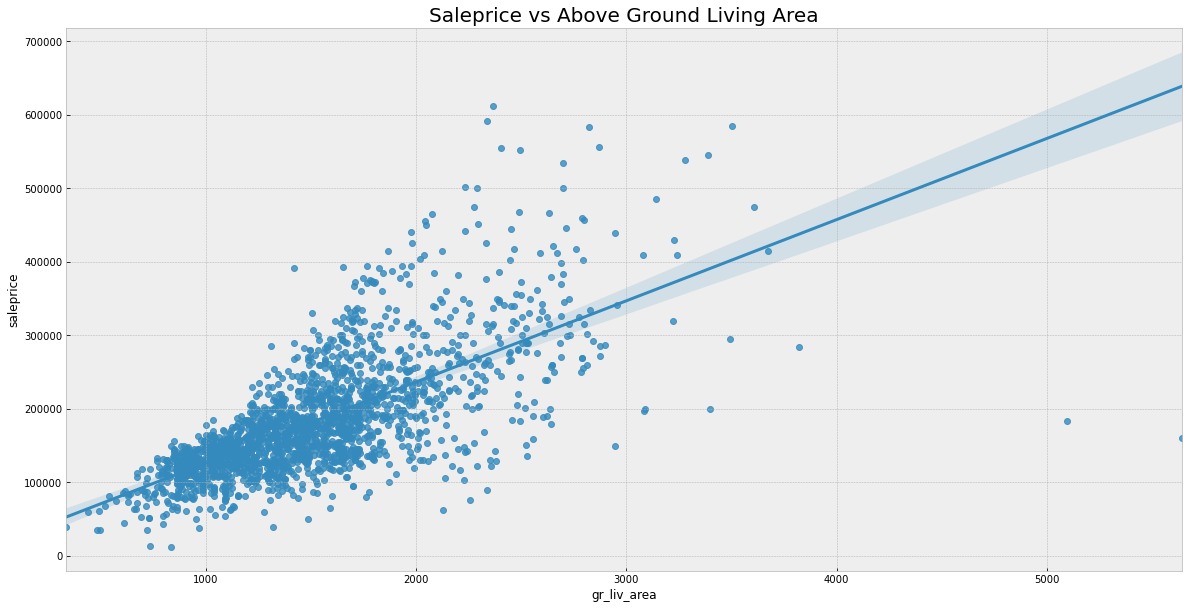

In [38]:
plt.figure(figsize = (20,10))
plt.title('Saleprice vs Above Ground Living Area', fontsize = 20)
sns.regplot(
            y = train['saleprice'],
            x = train['gr_liv_area']
);

In [39]:
train.loc[(train['gr_liv_area'] > 4000), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remodadd,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,NA,0,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5,3,NA,6,5644.0,1,0.0,466.0,6110.0,GasA,5,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,5,12,Typ,3,4,Attchd,2008.0,3,2.0,1418.0,3,3,Y,214,292,0,0,0,480,4,0,NA,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NA,2,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,5,3,PConc,5,3,NA,6,4010.0,1,0.0,1085.0,5095.0,GasA,5,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,5,15,Typ,2,4,Attchd,2008.0,3,3.0,1154.0,3,3,Y,546,484,0,0,0,0,0,0,Elev,17000,10,2007,New,183850


In [40]:
train_cleaned.drop(
    [train_cleaned.index[960],
    train_cleaned.index[1885]],
    inplace = True
)

In [41]:
train_cleaned.reset_index(drop = True, inplace = True)

### Anomalous Houses

As suggested by the author of the data file, 2 anomalous houses were identified and removed from the data set:
<ul>
    <li> 2 houses of unusual size that were priced appropriately for their sizes

In [42]:
# Seperation of metrics into separate Dataframes for further analysis and transformations

train_cleaned_continuous = train_cleaned[
    ['id', 'pid', 'saleprice', 'year_built', 'year_remodadd', 'lot_frontage', 
    'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
    'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 
    'garage_area', 'wood_deck_sf', 'open_porch_sf','enclosed_porch','3ssn_porch', 
    'screen_porch', 'pool_area']
]

train_cleaned_ordinal_1 = train_cleaned[
    ['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'heating_qc', 
    'kitchen_qual', 'fireplace_qu', 'garage_qual', 'garage_cond', 'pool_qc']
]

train_cleaned_ordinal_2 = train_cleaned[
    ['lot_shape', 'utilities', 'land_slope', 'bsmt_exposure', 'bsmtfin_type_1', 
    'bsmtfin_type_2', 'functional', 'paved_drive', 'fence', 'garage_finish']
]


train_cleaned_nominal = train_cleaned[
    ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config', 
    'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 
    'roof_style', 'roof_matl', 'mas_vnr_type', 'foundation', 'heating', 
    'central_air', 'garage_type', 'misc_feature', 'sale_type', 'saleprice']
]

train_cleaned_nominal_2 = train_cleaned[['exterior_1st', 'exterior_2nd', 'electrical', 'saleprice']]

train_cleaned_discrete = train_cleaned[['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 
                                        'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 
                                        'garage_cars', 'saleprice']]

### Continuous Statistics

#### Analysis

grlivarea correlates strongly with the following variables:
<ul>
    <li> totalbsmtsf
    <li> 1stflrsf
    <li> 2ndflrsf



In [43]:
train_cleaned_ordinal_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   exter_qual    2049 non-null   int64
 1   exter_cond    2049 non-null   int64
 2   bsmt_qual     2049 non-null   int64
 3   bsmt_cond     2049 non-null   int64
 4   heating_qc    2049 non-null   int64
 5   kitchen_qual  2049 non-null   int64
 6   fireplace_qu  2049 non-null   int64
 7   garage_qual   2049 non-null   int64
 8   garage_cond   2049 non-null   int64
 9   pool_qc       2049 non-null   int64
dtypes: int64(10)
memory usage: 160.2 KB


### Numerical Values

#### Boxplots of Numerical Values

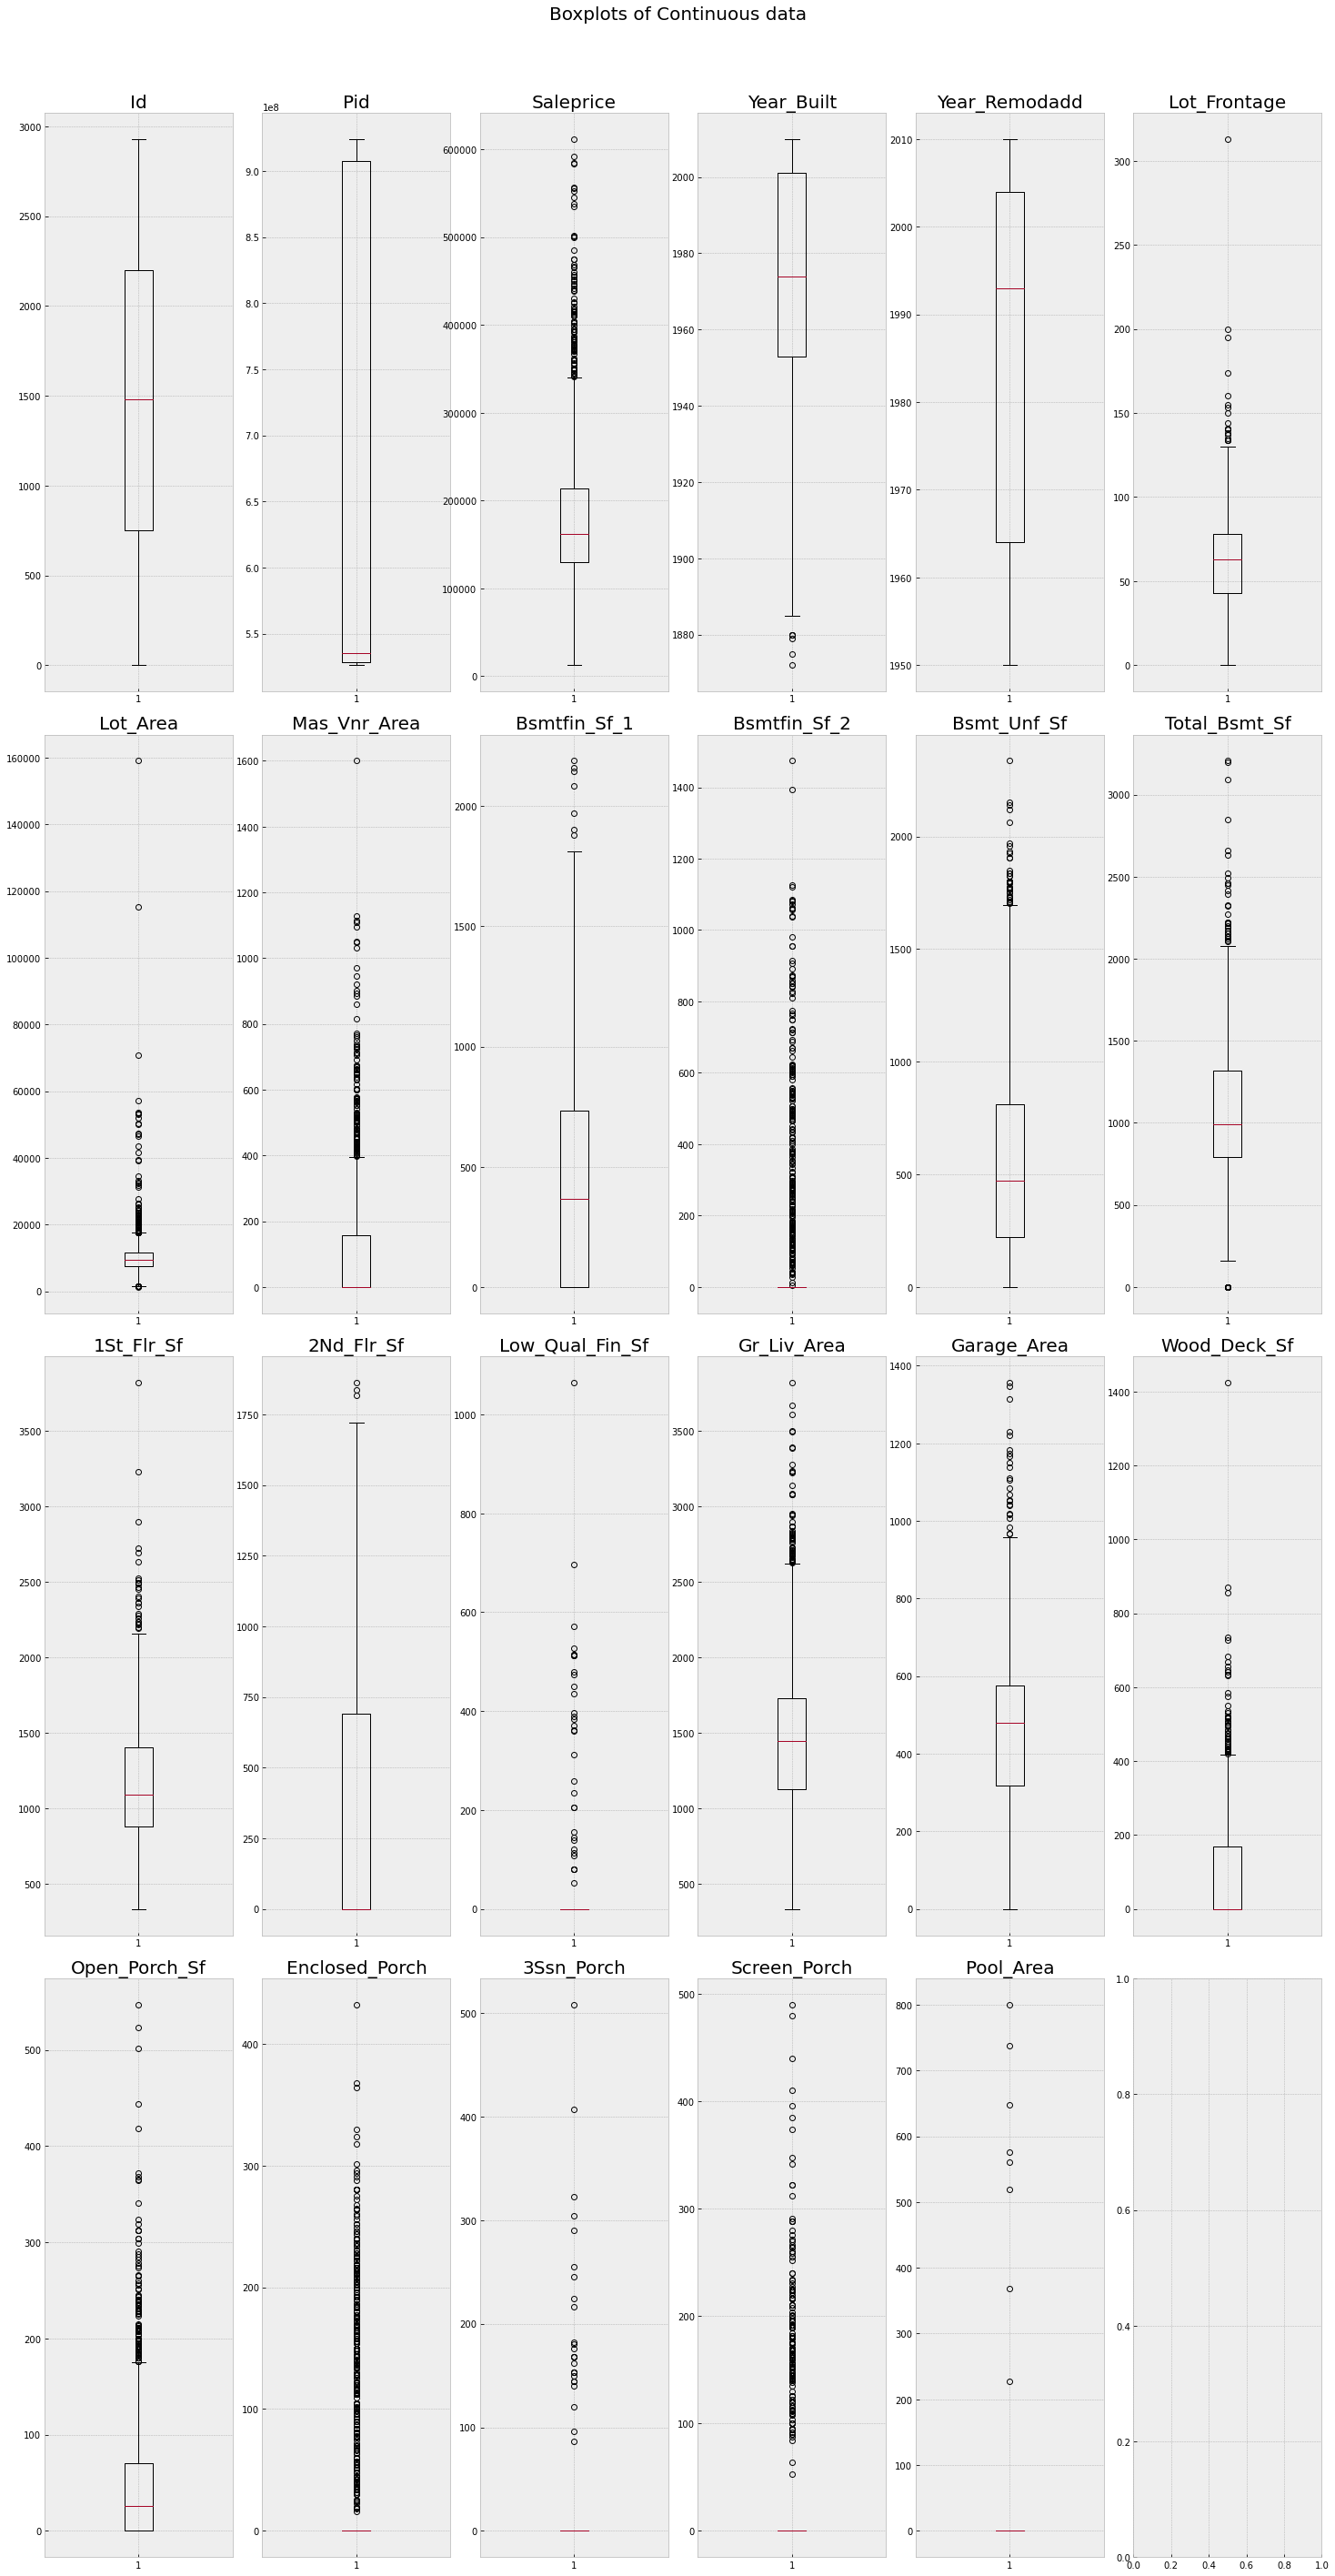

In [44]:
titles = list(train_cleaned_continuous.columns)

multi_plot_box(train_cleaned_continuous, 'Boxplots of Continuous data', titles, (20,40))

In [45]:
# Checking outliers for unusual variables
train_cleaned.loc[(train_cleaned['lot_frontage'] > 250) |
              (train_cleaned['lot_area'] > 100000) |
              (train_cleaned['mas_vnr_area'] > 1500) |
              (train_cleaned['bsmtfin_sf_2'] > 1200) |
              (train_cleaned['total_bsmt_sf'] > 3000) |
              (train_cleaned['wood_deck_sf'] > 1400) |
              (train_cleaned['enclosed_porch'] > 400)
              , :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remodadd,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
328,1773,528366050,20,RL,0.0,12692,Pave,NA,2,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,5,1992,1993,Hip,CompShg,BrkFace,BrkFace,None,0.0,4,3,PConc,4,3,NA,6,1231.0,1,0.0,1969.0,3200.0,GasA,5,Y,SBrkr,3228,0,0,3228,1.0,0.0,3,0,4,1,4,10,Typ,1,4,Attchd,1992.0,2,2.0,546.0,3,3,Y,264,75,291,0,0,0,0,0,NA,0,5,2007,WD,430000
471,2116,906426060,50,RL,0.0,159000,Pave,NA,1,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,4,3,CBlock,4,3,NA,3,697.0,1,0.0,747.0,1444.0,GasA,4,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,4,7,Typ,2,3,Attchd,1958.0,3,2.0,389.0,3,3,Y,0,98,0,0,0,0,0,0,Shed,500,6,2007,WD,277000
694,2072,905301050,20,RL,0.0,115149,Pave,NA,1,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,3,3,CBlock,4,3,NA,6,1219.0,1,0.0,424.0,1643.0,GasA,3,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,4,5,Typ,2,3,Attchd,1971.0,1,2.0,739.0,3,3,Y,380,48,0,0,0,0,0,0,NA,0,6,2007,WD,302000
770,2093,906201200,60,RL,86.0,10380,Pave,NA,2,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1986,1987,Gable,CompShg,Plywood,Plywood,BrkFace,172.0,4,3,CBlock,3,3,NA,2,28.0,5,1474.0,0.0,1502.0,GasA,5,Y,SBrkr,1553,1177,0,2730,1.0,0.0,2,1,4,1,4,8,Typ,1,3,Attchd,1987.0,3,2.0,576.0,3,3,Y,201,96,0,0,0,0,0,3,NA,0,8,2007,WD,301000
828,661,535381040,50,RL,60.0,10410,Pave,Grvl,3,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,4,5,1915,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,3,3,NA,1,0.0,1,0.0,1313.0,1313.0,GasA,3,Y,SBrkr,1313,0,1064,2377,0.0,0.0,2,0,3,1,4,8,Min2,1,3,Detchd,1954.0,1,2.0,528.0,3,3,Y,0,0,432,0,0,0,0,0,NA,0,6,2009,WD,142900
965,2294,923229100,80,RL,0.0,15957,Pave,NA,2,Low,AllPub,Corner,Mod,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,HdBoard,Plywood,None,0.0,3,3,PConc,4,3,NA,6,1148.0,1,0.0,96.0,1244.0,GasA,3,Y,SBrkr,1356,0,0,1356,2.0,0.0,2,0,3,1,3,6,Typ,1,3,Attchd,1977.0,3,2.0,528.0,3,3,Y,1424,0,0,0,0,0,0,3,NA,0,9,2007,WD,188000
1146,445,528142130,20,RL,85.0,10655,Pave,NA,2,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,4,3,PConc,4,3,NA,6,1124.0,0,479.0,1603.0,3206.0,GasA,5,Y,SBrkr,1629,0,0,1629,1.0,0.0,2,0,3,1,4,7,Typ,1,4,Attchd,2003.0,2,3.0,880.0,3,3,Y,0,0,0,0,0,0,0,0,NA,0,10,2009,WD,284000
1163,424,528106020,20,RL,105.0,15431,Pave,NA,3,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,5,3,PConc,5,3,NA,6,1767.0,5,539.0,788.0,3094.0,GasA,5,Y,SBrkr,2402,0,0,2402,1.0,0.0,2,0,2,1,5,10,Typ,2,4,Attchd,2008.0,3,3.0,672.0,3,3,Y,0,72,0,0,170,0,0,0,NA,0,4,2009,WD,555000
1334,1266,535427070,20,RL,313.0,27650,Pave,NA,1,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,4,3,NA,6,425.0,1,0.0,160.0,585.0,GasA,5,Y,SBrkr,2069,0,0,2069,1.0,0.0,2,0,4,1,4,9,Typ,1,4,Attchd,1960.0,2,2.0,505.0,3,3,Y,0,0,0,0,0,0,0,0,NA,0,11,2008,WD,242000
1408,1850,533241030,60,FV,66.0,7399,Pave,Pave,2,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,

In [46]:
column_drop_list = [['id', 'pid']]

#### Outliers

The following outliers were examined based on their placement on the boxplots but due to no extenuating circumstance, all rows were kept. 

However, id and pid do not give any information beyond identifying the houses. The district information given by pid could be better covered by a combination of zoning and neighbourhood. As a result, both will be dropped from the data set.

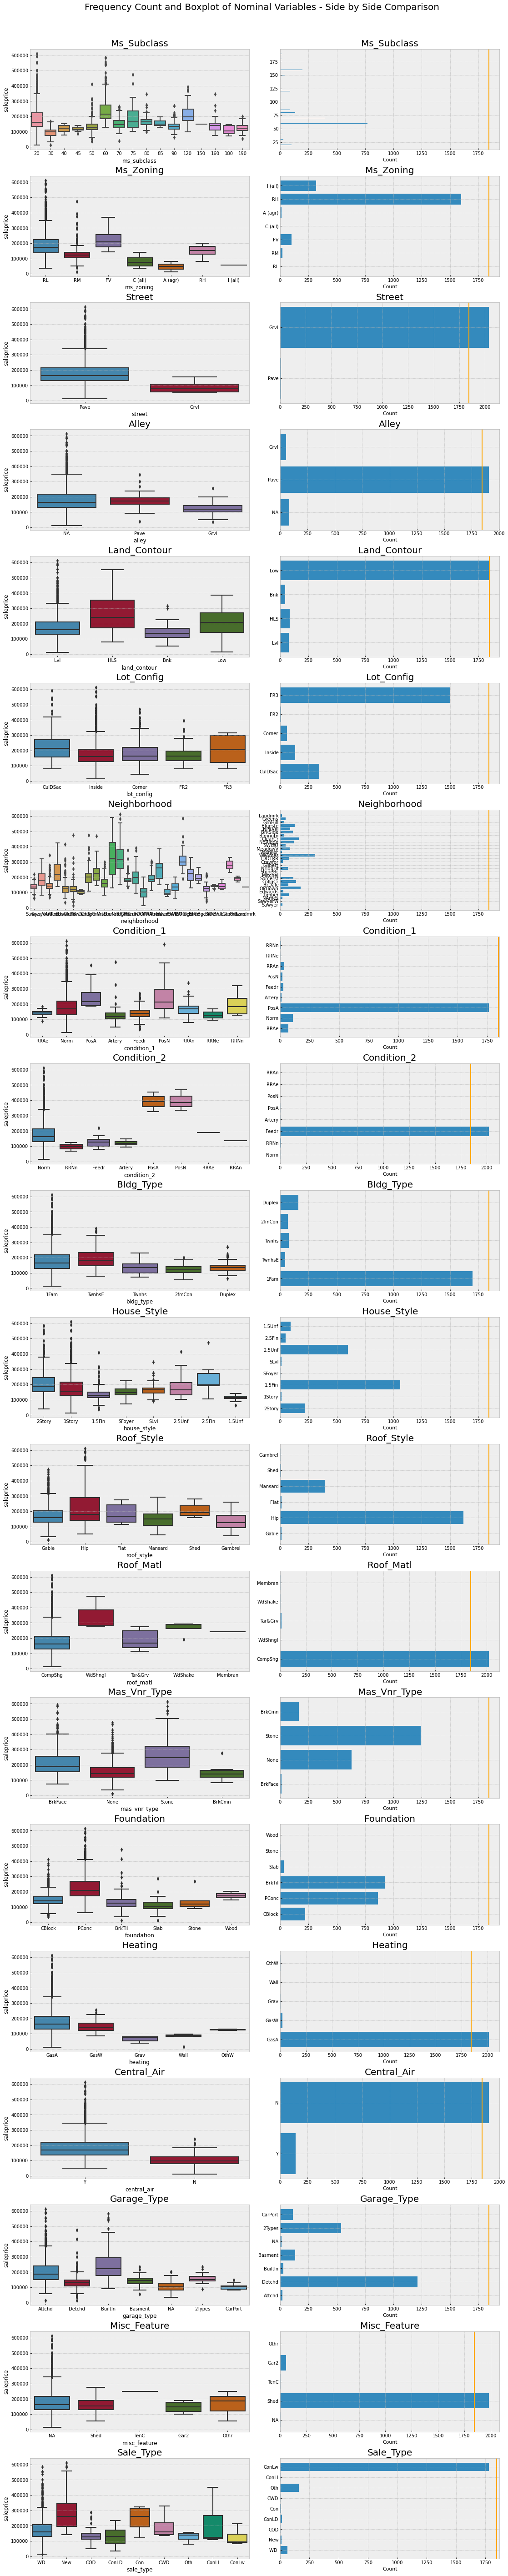

In [47]:
titles = list(train_cleaned_nominal.columns)

multi_plot_box_nominal(train_cleaned_nominal, 'Frequency Count and Boxplot of Nominal Variables - Side by Side Comparison', 
                       titles, (15, 80));

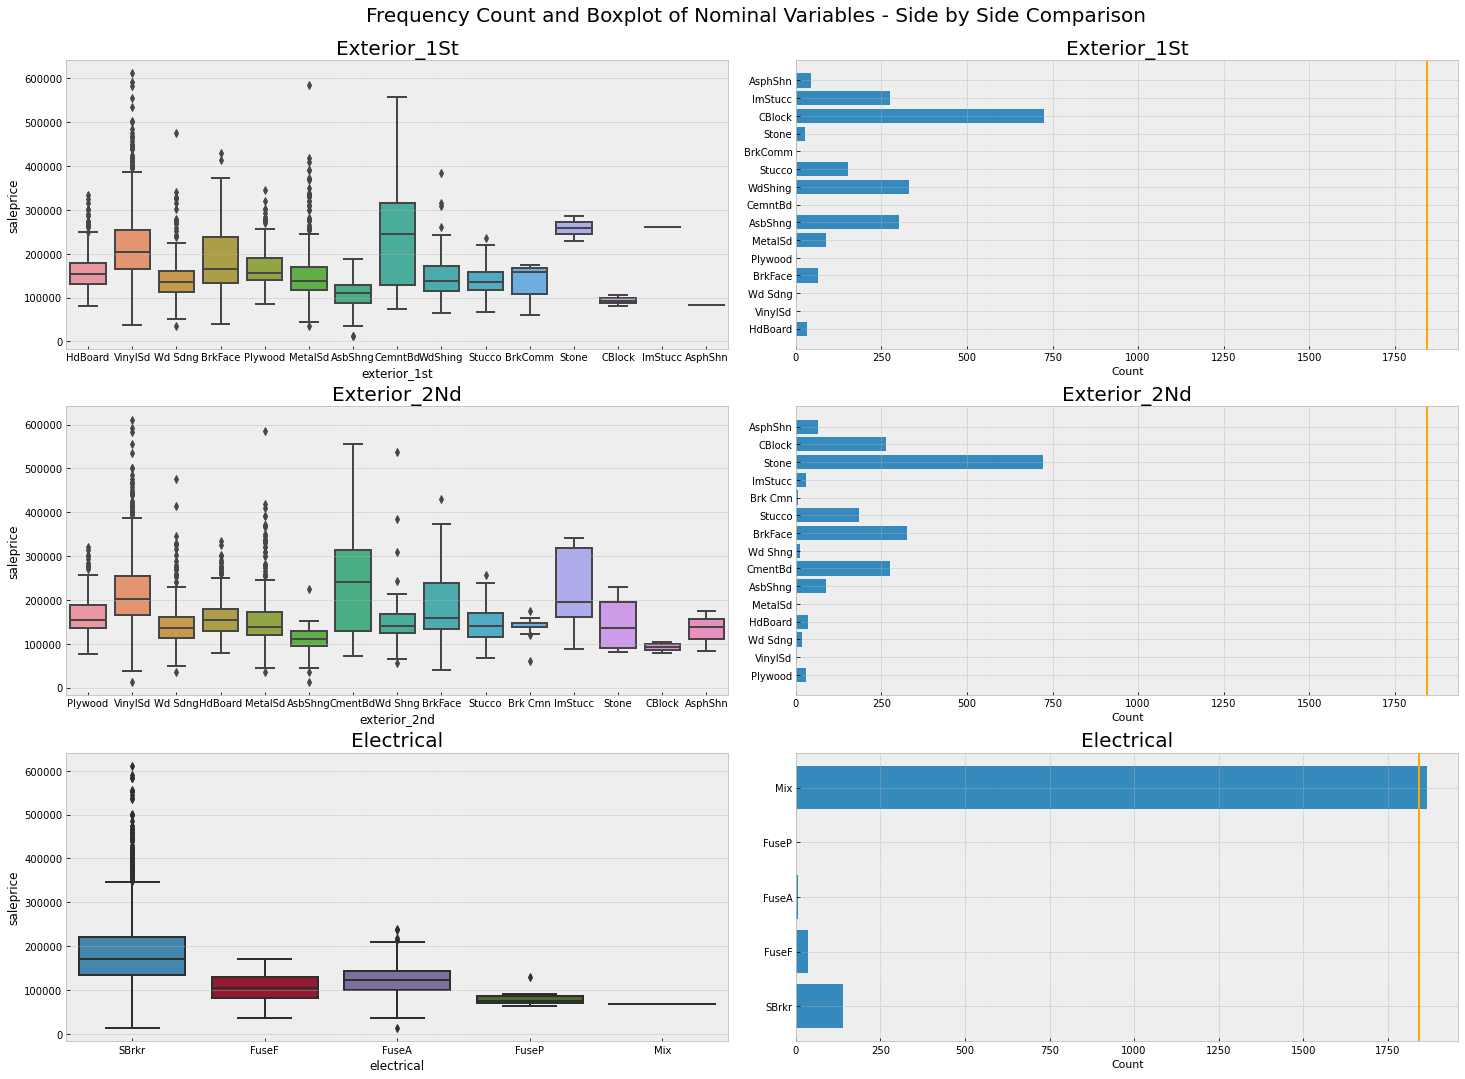

In [48]:
titles = list(train_cleaned_nominal_2.columns)

multi_plot_box_nominal(train_cleaned_nominal_2, 'Frequency Count and Boxplot of Nominal Variables - Side by Side Comparison', 
                       titles, (20, 15));

In [49]:
print(threshold_to_drop(train_cleaned_nominal))
print(threshold_to_drop(train_cleaned_nominal_2));

The columns that exceeded a threhold of 90% of the population are:
['street', 'alley', 'condition_2', 'roof_matl', 'heating', 'central_air', 'misc_feature']
The columns that exceeded a threhold of 90% of the population are:
['electrical']


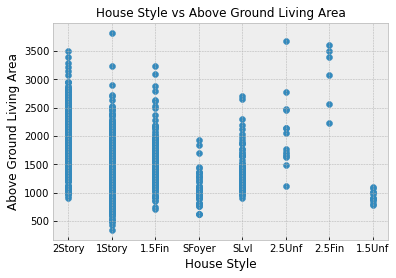

In [50]:
plt.scatter(
    x = train_cleaned['house_style'],
    y = train_cleaned['gr_liv_area']
)

plt.title('House Style vs Above Ground Living Area', fontsize = 12)
plt.xlabel('House Style', fontsize = 12)
plt.ylabel('Above Ground Living Area', fontsize = 12);

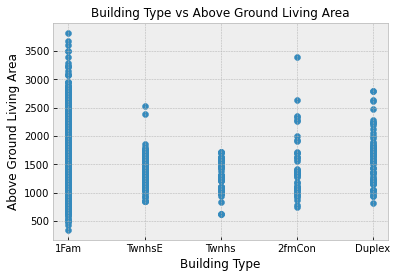

In [51]:
plt.scatter(
    x = train_cleaned['bldg_type'],
    y = train_cleaned['gr_liv_area']
)

plt.title('Building Type vs Above Ground Living Area', fontsize = 12)
plt.xlabel('Building Type', fontsize = 12)
plt.ylabel('Above Ground Living Area', fontsize = 12);

### Nominal Variables

Based on most of the houses (90%) falling into one category for the following variables, they will be dropped:

<ul>
    <li> Street
    <li> Alley
    <li> Roof Material
    <li> Heating
    <li> Central Air
    <li> Electrical
</ul>

Additionally, these variables were also dropped:

<ol>
   <li> Lot Config - This shows an almost complete overlap in price per lot, with no distinguishing features.     
   <br>
   <br> 
   <li> House Style - The graph for this house is well covered by a similar graph for Above Ground Living Area, which also has the advantage of being continuous. As such, we will drop this column.
   <br>
   <br>  
   <li> Misc Feature - Miscellaneous Features did not show an appreciable difference in price between each feature, with the exception of the Tennis, which was priced much higher. However, as we only have 1 data point with a tennis court, it is not enough data to model and it will be dropped.   
   <br>
   <br>  
   <li> Condition 1 & 2 - Due to the significance of being adjacent or near to a positive offsite feature, a new column will be made for either of these, to combine data, as condition 2 has too few data points on its own.
   </ol>
   <br>  
Considerations were also made for the following variable(s):
<ol>
   <li> Building Type - The Above Ground Living Area quite closely mimics the distribution of Building Type, to prevent collinearity, we will drop the building type and assume that Above Ground Living Area is representative of the general amount of space you would get for each building type.
   <br>
   <br>      
   <li> MS Zoning - The variable will likely be strongly correlated with the neighborhood variable
   <br>
   <br>      
   <li> MS Sub Class - The subclasses that showed the largest price increase were:
<ul>
    <li> 020	1-STORY 1946 & NEWER ALL STYLES
    <li> 060	2-STORY 1946 & NEWER
    <li> 120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
</ul>      
Because age is already a new metric and because there is already a metric for square footage of the 2 floors, this metric will be dropped from the dataset.

In [52]:
train_cleaned = train_cleaned.apply(pos_feature, axis=1)

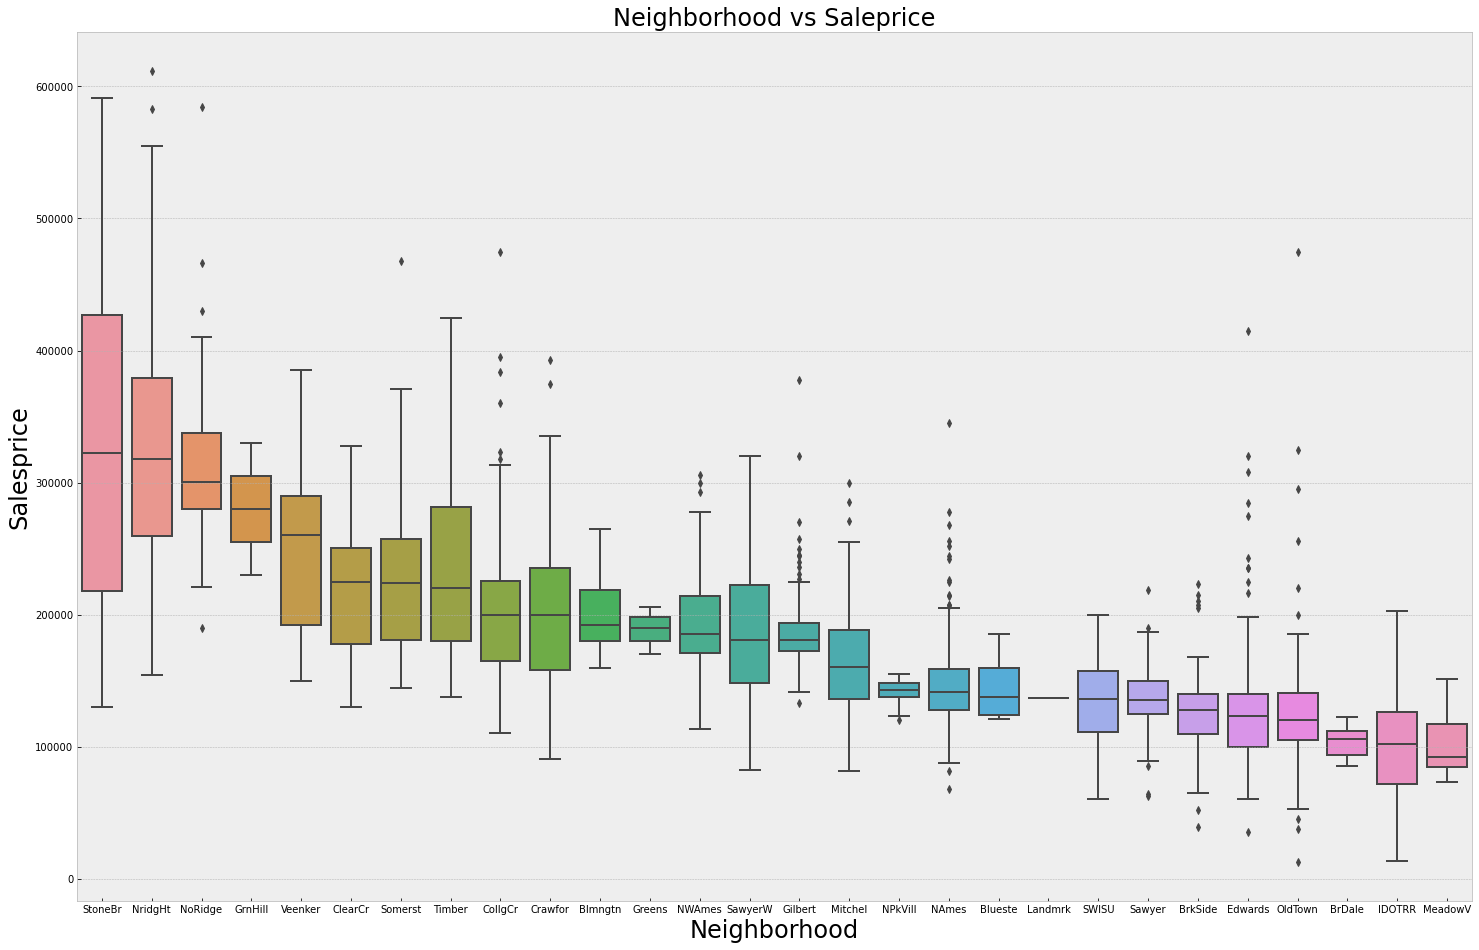

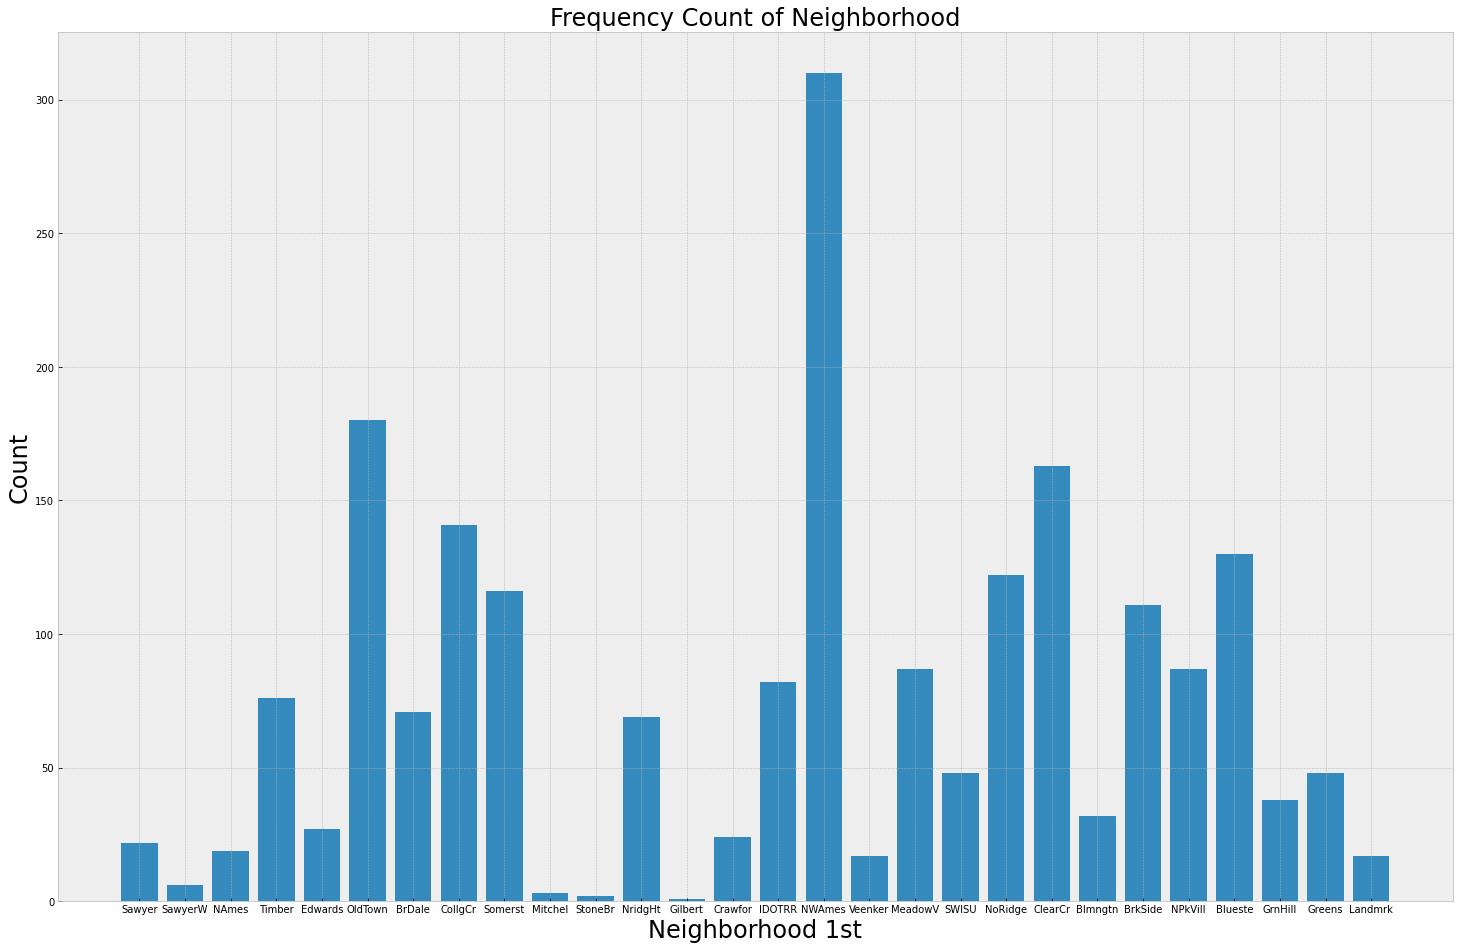

In [53]:
# Creating a dictionary of neighborhood and saleprice
train_neighbourhood = train_cleaned[['saleprice', 'neighborhood']]
train_neighbourhood_grouped = train_neighbourhood.groupby('neighborhood')
train_neighbourhood_sorted = pd.DataFrame({col:vals['saleprice'] for col,vals in train_neighbourhood_grouped})

# Re-sorting the neighbourhood plot to show neighborhoods by median value
meds = train_neighbourhood_sorted.median()
meds.sort_values(ascending=False, inplace=True)
train_neighbourhood_sorted = train_neighbourhood_sorted[meds.index]

# Boxplot of Neighborhood vs Saleprice
plt.figure(figsize=(25, 16))
sns.boxplot(
    data= train_neighbourhood_sorted
)
plt.title('Neighborhood vs Saleprice', fontsize = 24)
plt.xlabel('Neighborhood', fontsize = 24)
plt.ylabel('Salesprice', fontsize = 24)

# Frequency plot of Neighborhoods
plt.figure(figsize=(25, 16))
plt.bar(
    x = train_cleaned['neighborhood'].unique(),
    height = train_cleaned.groupby('neighborhood')['neighborhood'].value_counts(),
    data= train_cleaned
)
plt.title('Frequency Count of Neighborhood', fontsize = 24)
plt.ylabel('Count', fontsize = 24)
plt.xlabel('Neighborhood 1st', fontsize = 24);

In [54]:
# Dictionary of neighborhoods to use to sort categories into tiers based on median pricing
neighborhood_dict = {
    'tier_1': ['StoneBr', 'NridgHt', 'NoRidge', 'GrnHill'],
    'tier_2': ['Veenker', 'ClearCr', 'Somerst', 'Timber Cmn', 'CollgCr', 'Crawfor', 'Blmngtn', 'Greens', 
               'NWAmes', 'SawyerW', 'Gilbert', 'Mitchel'],
    'tier_3': ['NPkVill', 'NAmes', 'Blueste', 'Landmrk', 'SWISU', 'Sawyer'],
    'tier_4': ['BrkSide', 'Edwards', 'OldTown'],
    'tier_5': ['BrDale', 'IDOTRR', 'MeadowV'],
}

# Swap key:value pairs for re-mapping
exterior_2_dict_map = {v : k for k, V in neighborhood_dict.items() for v in V}
train_cleaned['neighborhood'] = train_cleaned['neighborhood'].map(exterior_2_dict_map)

#### Neighborhood

Neighborhood will be grouped into smaller groups of similar medians in the following category:

 - upperclass - StoneBr, NridgHt, NoRidge, GrnHill
 - uppermiddle - Veenker, ClearCr, Somerst, Timber, CollgCr, Crawfor, Blmngtn, Greens, NWAmes, SawyerW, Gilbert, Mitchel
 - middleclass - NPkVill, NAmes, Blueste, Landmrk, SWISU, Sawyer
 - lowermiddle - BrkSide, Edwards, OldTown
 - rural - BrDale, IDOTRR, MeadowV

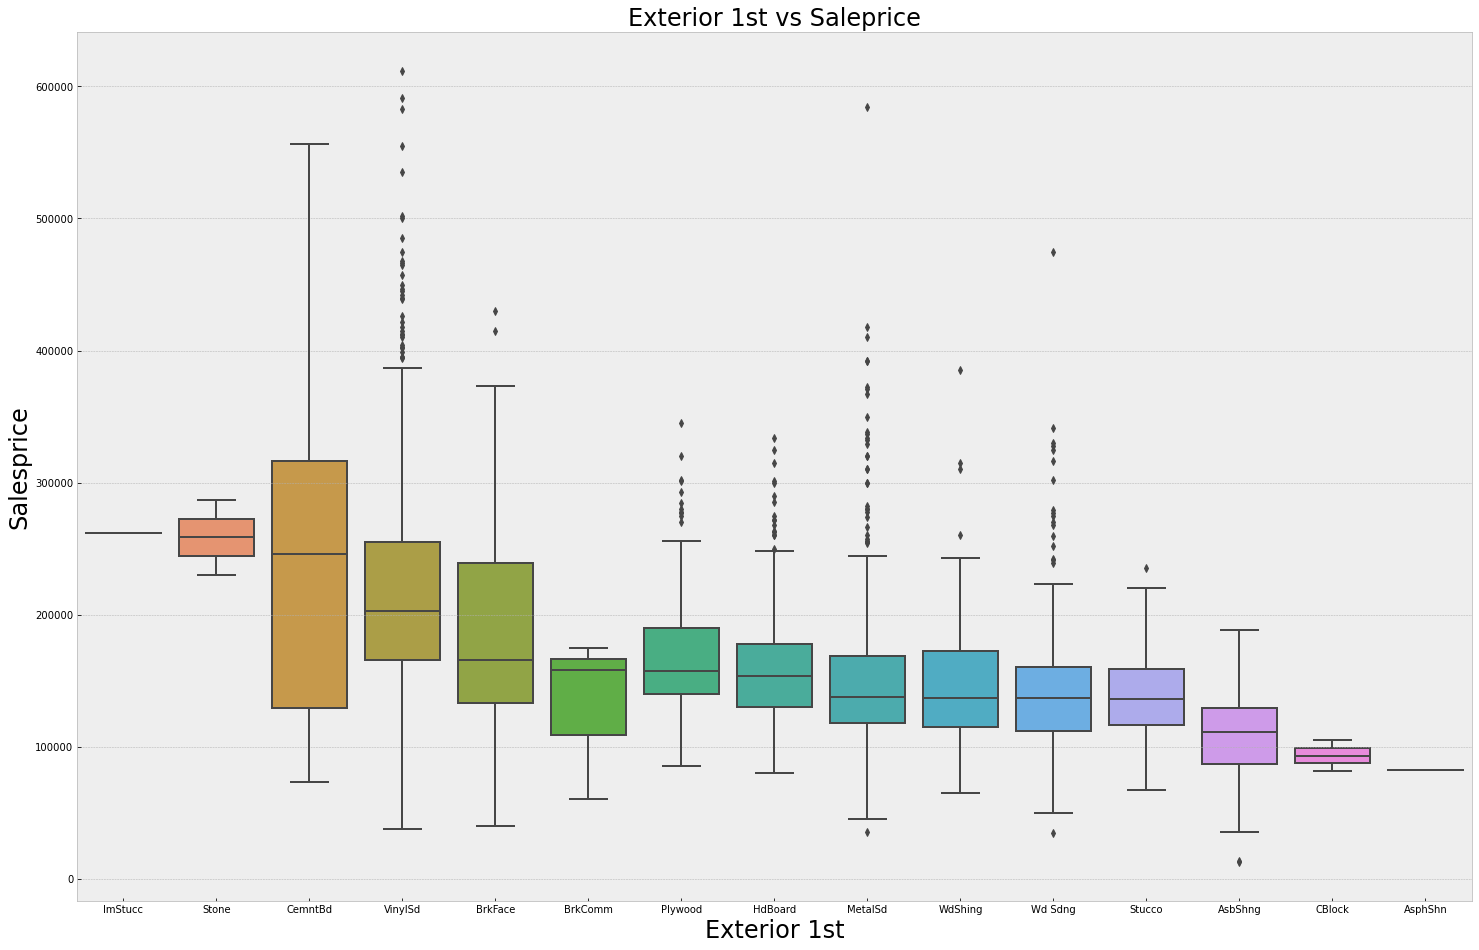

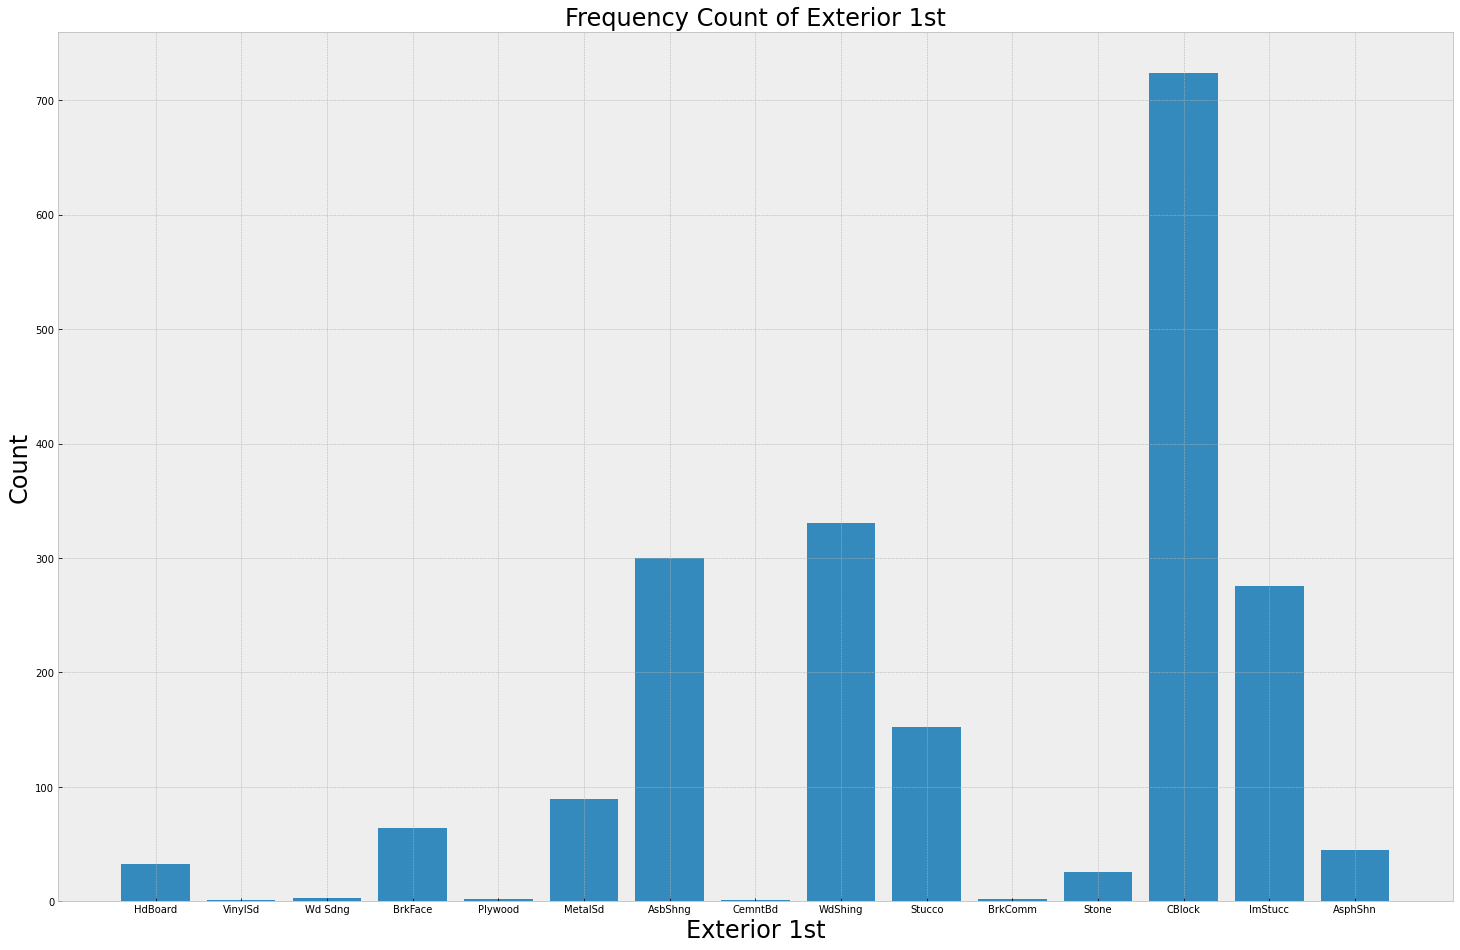

In [55]:
# Creating a dictionary of exterior 1st and saleprice
train_exterior_1 = train_cleaned[['saleprice', 'exterior_1st']]
train_exterior_1_grouped = train_exterior_1.groupby('exterior_1st')
train_exterior_1_grouped_sorted = pd.DataFrame({col:vals['saleprice'] for col,vals in train_exterior_1_grouped})

# Re-sorting the exterior 1st plot to show exterior 1st by median value
meds = train_exterior_1_grouped_sorted.median()
meds.sort_values(ascending=False, inplace=True)
train_exterior_1_grouped_sorted = train_exterior_1_grouped_sorted[meds.index]

# Boxplot of exterior 1st vs Saleprice
plt.figure(figsize=(25, 16))
sns.boxplot(
    data= train_exterior_1_grouped_sorted
)
plt.title('Exterior 1st vs Saleprice', fontsize = 24)
plt.xlabel('Exterior 1st', fontsize = 24)
plt.ylabel('Salesprice', fontsize = 24)

# Frequency plots of exterior 1st categories
plt.figure(figsize=(25, 16))
plt.bar(
    x = train_cleaned['exterior_1st'].unique(),
    height = train_cleaned.groupby('exterior_1st')['exterior_1st'].value_counts(),
    data= train_cleaned
)
plt.title('Frequency Count of Exterior 1st', fontsize = 24)
plt.ylabel('Count', fontsize = 24)
plt.xlabel('Exterior 1st', fontsize = 24);

In [56]:
train_cleaned.loc[
    ((train_cleaned['saleprice'] > 400000) &
    (train_cleaned['exterior_1st'] == 'Wd Sdng')) |
    ((train_cleaned['saleprice'] > 500000) &
    (train_cleaned['exterior_1st'] == 'MetalSd')),
    :             
]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remodadd,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,positive_feature
1034,2667,902400110,75,RM,90.0,22950,Pave,NA,1,Lvl,AllPub,Inside,Gtl,tier_4,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,4,BrkTil,3,3,NA,1,0.0,1,0.0,1107.0,1107.0,GasA,5,Y,SBrkr,1518,1518,572,3608,0.0,0.0,2,1,4,1,5,12,Typ,2,3,Detchd,1993.0,1,3.0,840.0,5,3,Y,0,260,0,0,410,0,0,4,NA,0,6,2006,WD,475000,1
1691,2451,528360050,60,RL,114.0,17242,Pave,NA,2,Lvl,AllPub,Inside,Gtl,tier_1,Norm,Norm,1Fam,2Story,9,5,1993,1994,Hip,CompShg,MetalSd,MetalSd,BrkFace,738.0,4,4,PConc,5,3,NA,3,292.0,6,1393.0,48.0,1733.0,GasA,5,Y,SBrkr,1933,1567,0,3500,1.0,0.0,3,1,4,1,5,11,Typ,1,3,Attchd,1993.0,2,3.0,959.0,3,3,Y,870,86,0,0,210,0,0,0,NA,0,5,2006,WD,584500,1


#### Exterior 1 of the Building

When looking at outliers for the Exterior types of buildings, one thing to note is that the two properties also have above average Exterior Qualities, Exterior Conditions, and houses that rate very highly on overall quality.

Outliers were kept for this reason, as their price is probably more tied to the condition of the house than the type of exterior used.

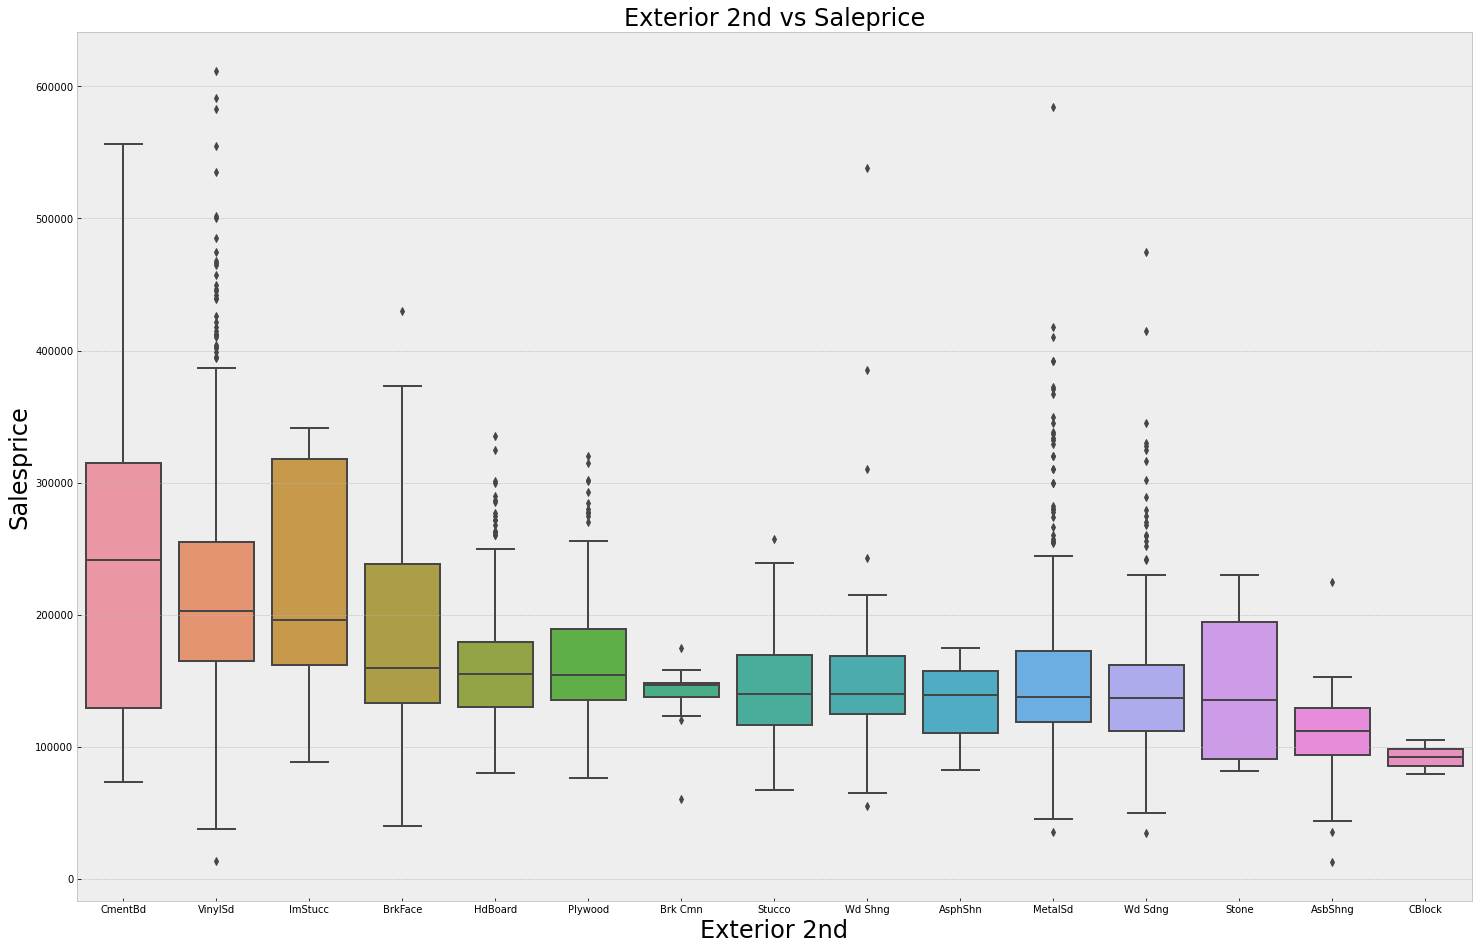

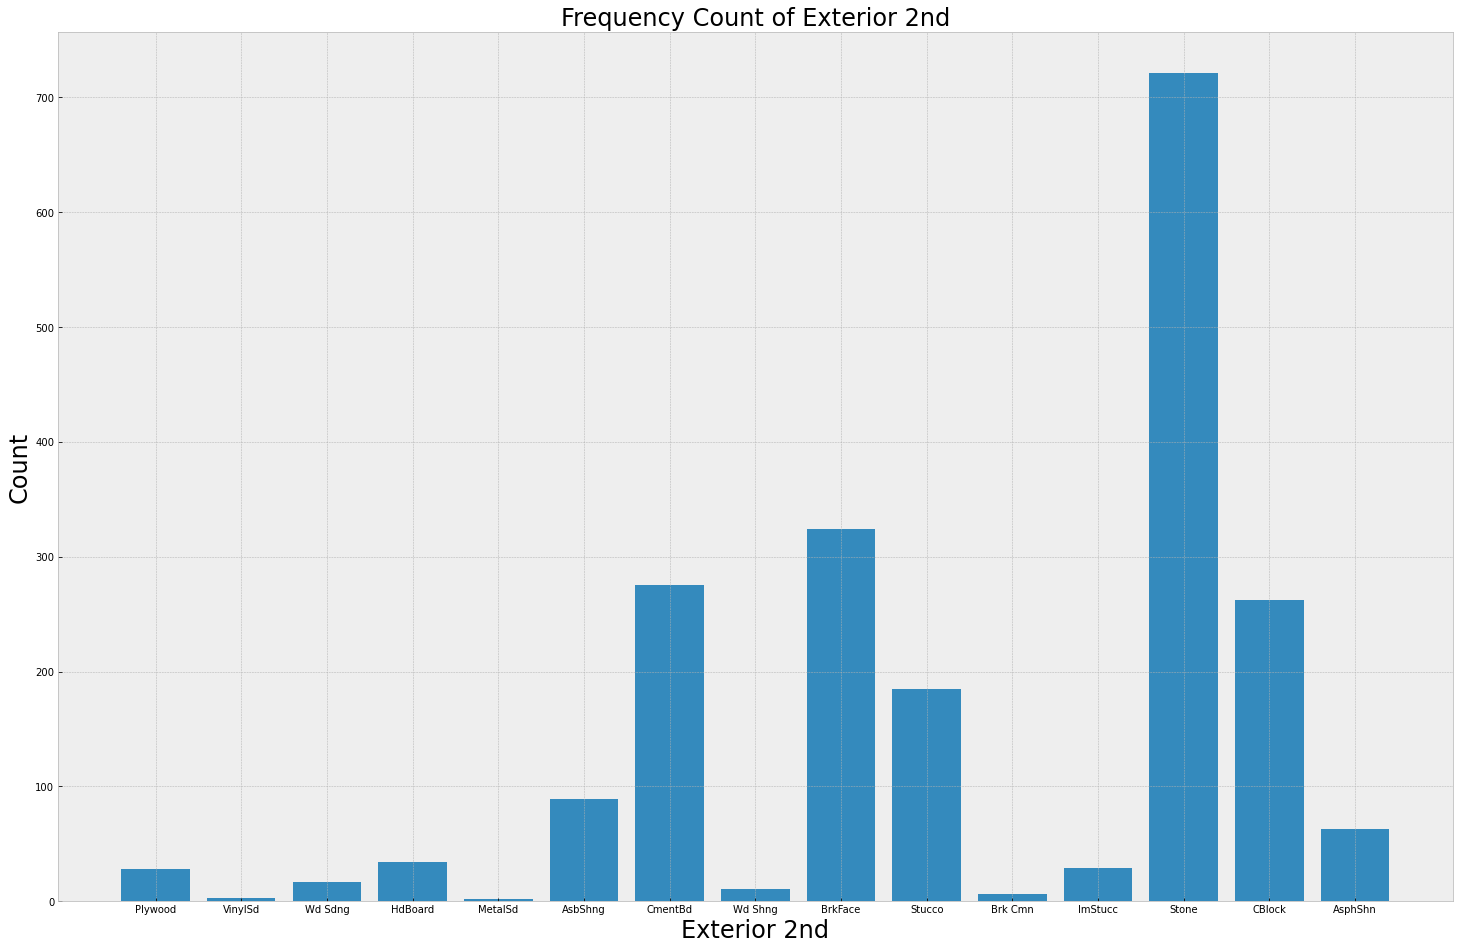

In [57]:
# Creating a dictionary of exterior 2nd and saleprice
train_exterior_2 = train_cleaned[['saleprice', 'exterior_2nd']]
train_exterior_2_grouped = train_exterior_2.groupby('exterior_2nd')
train_exterior_2_grouped_sorted = pd.DataFrame({col:vals['saleprice'] for col,vals in train_exterior_2_grouped})

# Re-sorting the exterior 2nd plot to show exterior 2nd by median value
meds = train_exterior_2_grouped_sorted.median()
meds.sort_values(ascending=False, inplace=True)
train_exterior_2_grouped_sorted = train_exterior_2_grouped_sorted[meds.index]

# Boxplot of exterior 2nd vs Saleprice
plt.figure(figsize=(25, 16))
sns.boxplot(
    data= train_exterior_2_grouped_sorted
)
plt.title('Exterior 2nd vs Saleprice', fontsize = 24)
plt.xlabel('Exterior 2nd', fontsize = 24)
plt.ylabel('Salesprice', fontsize = 24);

# Frequency plot of exterior 2nd
plt.figure(figsize=(25, 16))
plt.bar(
    x = train_cleaned['exterior_2nd'].unique(),
    height = train_cleaned.groupby('exterior_2nd')['exterior_2nd'].value_counts(),
    data= train_cleaned
);
plt.title('Frequency Count of Exterior 2nd', fontsize = 24)
plt.ylabel('Count', fontsize = 24)
plt.xlabel('Exterior 2nd', fontsize = 24);

In [58]:
train_cleaned.loc[
    (train_cleaned['saleprice'] > 500000) &
    ((train_cleaned['exterior_2nd'] == 'Wd Shng') |
    (train_cleaned['exterior_2nd'] == 'MetalSd')),
    :             
]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remodadd,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,positive_feature
823,16,527216070,60,RL,47.0,53504,Pave,NA,1,HLS,AllPub,CulDSac,Mod,tier_1,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,5,3,PConc,4,3,NA,5,1416.0,1,0.0,234.0,1650.0,GasA,5,Y,SBrkr,1690,1589,0,3279,1.0,0.0,3,1,4,1,5,12,Mod,1,4,BuiltIn,2003.0,3,3.0,841.0,3,3,Y,503,36,0,0,210,0,0,0,NA,0,6,2010,WD,538000,1
1691,2451,528360050,60,RL,114.0,17242,Pave,NA,2,Lvl,AllPub,Inside,Gtl,tier_1,Norm,Norm,1Fam,2Story,9,5,1993,1994,Hip,CompShg,MetalSd,MetalSd,BrkFace,738.0,4,4,PConc,5,3,NA,3,292.0,6,1393.0,48.0,1733.0,GasA,5,Y,SBrkr,1933,1567,0,3500,1.0,0.0,3,1,4,1,5,11,Typ,1,3,Attchd,1993.0,2,3.0,959.0,3,3,Y,870,86,0,0,210,0,0,0,NA,0,5,2006,WD,584500,1


#### Exterior 2 of the Building

Similarly to Exterior 1, outliers for the 2nd Exterior of buildings, also have above average Exterior Qualities, Exterior Conditions, and houses that rate very highly on overall quality.

This may indicate that these 3 qualities are more correlated with sale price and could be used as a proxy for Exterior Type instead.

In [59]:
column_drop_list.append(
    ['ms_subclass', 'ms_zoning', 'street', 'alley', 'roof_matl', 'heating', 'central_air', 'electrical',
    'lot_config', 'house_style','misc_feature', 'condition_1', 'condition_2'])

#### Testing Nominal Variables

In [60]:
train_cleaned_nominal = [
    'land_contour', 'neighborhood', 'bldg_type','roof_style', 'mas_vnr_type', 'foundation', 
    'exterior_1st', 'exterior_2nd', 'garage_type', 'sale_type', 'mo_sold']

In [61]:
nominal_list = []

# Iterate through categories in each nominal variable
for col_name in train_cleaned_nominal:
    train_variable_dummified = pd.get_dummies(columns=[col_name], drop_first=True, data=train_cleaned[col_name])
    X = train_variable_dummified
    y = train_cleaned['saleprice']
    # Model linear regression of sale price for each category to determine if there is a 
    # significant difference in coefficients and if the RMSE is not too large
    model = LinearRegression()
    model.fit(X, y)
    print(f'{col_name.title()}')
    print('The coeffecients for {col_name} are:')
    print(set(zip(X.columns, model.coef_)))
    y_pred = model.predict(X)
    mse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    print(f'The Root Mean Squared Error for the variable {col_name} is {mse}')
    print('-------------------------------')
    nominal_list.append([col_name, mse])

Land_Contour
The coeffecients for {col_name} are:
{('Lvl', 36874.82125019125), ('HLS', 120229.63288084455), ('Low', 57189.372689326156)}
The Root Mean Squared Error for the variable land_contour is 77086.14475002489
-------------------------------
Neighborhood
The coeffecients for {col_name} are:
{('tier_4', -179732.93916768645), ('tier_3', -164177.39456876784), ('tier_2', -106679.89721609215), ('tier_5', -205775.23089701022)}
The Root Mean Squared Error for the variable neighborhood is 53977.20555423832
-------------------------------
Bldg_Type
The coeffecients for {col_name} are:
{('TwnhsE', 13020.961598958203), ('2fmCon', -62111.51976750137), ('Twnhs', -52191.41107184915), ('Duplex', -45995.077738515916)}
The Root Mean Squared Error for the variable bldg_type is 77654.44272701001
-------------------------------
Roof_Style
The coeffecients for {col_name} are:
{('Mansard', -38970.219780219806), ('Gable', -20348.823680334524), ('Shed', 17053.589743589695), ('Hip', 33019.10535540407), (

In [62]:
print('The order of nominal variables by root mean squared error is:')
order = sorted([v for k, v in nominal_list])
for i in order:
    for n in nominal_list:
        if i == n[1]:
            print(n)
            
train_nominal_final = [k for k, v in nominal_list if v <= 70000]

The order of nominal variables by root mean squared error is:
['neighborhood', 53977.20555423832]
['foundation', 66851.72560264109]
['garage_type', 68264.49231024025]
['mas_vnr_type', 70735.35210485314]
['exterior_1st', 71241.85240343481]
['exterior_2nd', 71903.54008517425]
['sale_type', 73324.9003165812]
['roof_style', 76340.03017354068]
['land_contour', 77086.14475002489]
['bldg_type', 77654.44272701001]
['mo_sold', 78912.80248671201]


The nominal variables that are most predictive of sale price are with a root mean squared error < 70000:
<ol>
    <li> Neighbourhood
    <li> Foundation
    <li> Garage Type
</ol>

The following nominal variables will be dropped:
<ul>
    <li> Roof Style
    <li> Land Contour
    <li> Building Type
    <li> Masonry Veneer Type
    <li> Exterior 1st
    <li> Exterior 2nd
    <li> Sale Type
</ul>
Lastly, based on the root mean squared error, we will also drop Month Sold, despite initial analysis.

In [63]:
column_drop_list.append(
    ['mas_vnr_type', 'exterior_1st', 'exterior_2nd', 'sale_type', 'roof_style', 'land_contour', 
    'bldg_type', 'mo_sold'])

In [64]:
# One Hot Encode nominal variables
keep_nominal = ['neighborhood', 'foundation', 'garage_type'] # Variables to be kept
ohe = OneHotEncoder(sparse = False, handle_unknown = 'error', drop = 'first') # Instantiate OHE model
ohe.fit(train_cleaned[keep_nominal])                           # Fit model
train_dummified_values = ohe.transform(train_cleaned[keep_nominal]) # Transform model
column_names = ohe.get_feature_names(keep_nominal)
train_dummified = pd.DataFrame(train_dummified_values, columns = column_names) #Dataframe with nominal values

### Age Related Variables

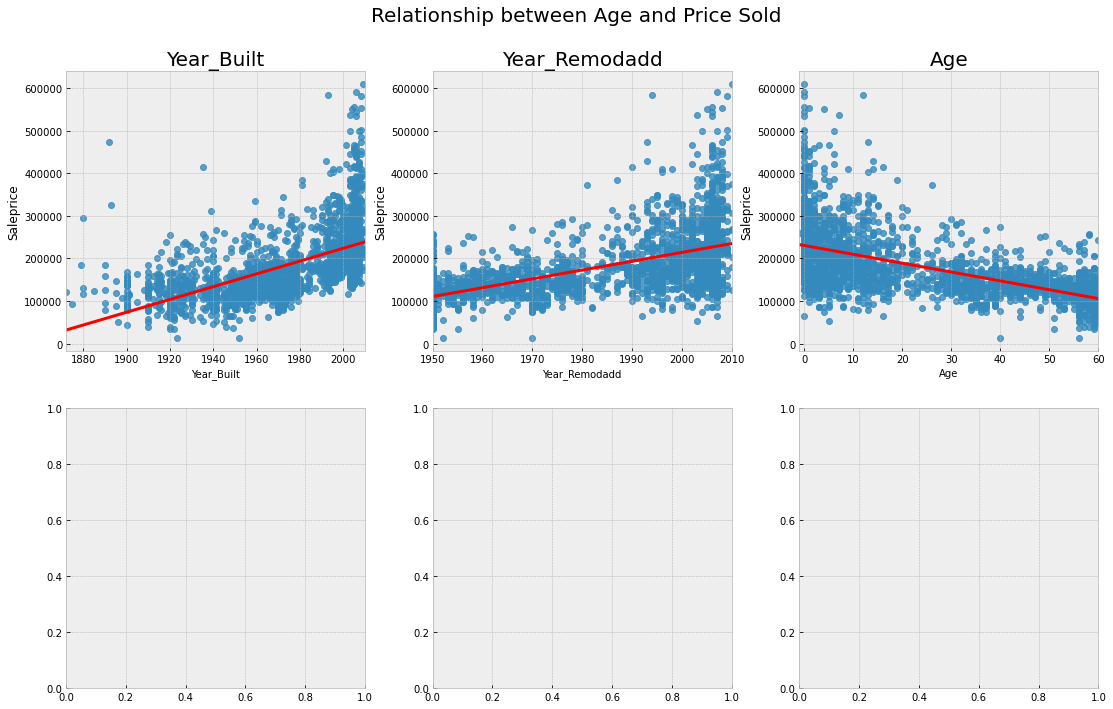

In [65]:
def house_age(row):
    age1 = row['yr_sold'] - row['year_built']
    age2 = row['yr_sold'] - row['year_remodadd']
    row['age'] = min(age1, age2)
    return row

train_cleaned = train_cleaned.apply(house_age, axis=1)

age_variables = ['year_built', 'year_remodadd', 'age', 'saleprice']

multi_plot_scatter(train_cleaned[age_variables], 'Relationship between Age and Price Sold', age_variables, (15,10))

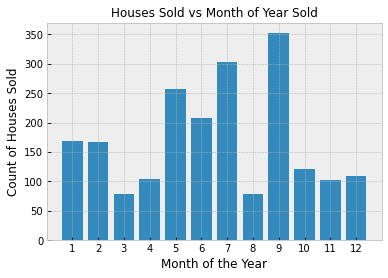

In [66]:
plt.bar(
    x = train_cleaned['mo_sold'].unique(),
    height = train_cleaned.groupby('mo_sold')['mo_sold'].count(),
)

plt.title('Houses Sold vs Month of Year Sold', fontsize = 12)
plt.ylabel('Count of Houses Sold', fontsize = 12)
plt.xlabel('Month of the Year', fontsize = 12)
plt.xticks(range(1,13));

In [67]:
calendar = {1: 'jan',
            2: 'feb',
            3: 'mar',
            4: 'apr',
            5: 'may',
            6: 'jun',
            7: 'jul',
            8: 'aug',
            9: 'sep',
            10: 'oct',
            11: 'nov',
            12: 'dec'
}
train_cleaned['mo_sold'] = train_cleaned['mo_sold'].map(calendar)

There's a clear advantage to younger houses, whether that is measured by the age of the house, or the age of the remodel, as well as younger garages.

One custom features were created:
1. The younger of the age of the house and the age of the remodel, and this will be trialed in the model to see if there's an improvement

Month sold will also be kept, as there is a clear advantage to selling in the summer months, which seems to impact sale price. It is possible that people are unlikely to want to leave the house in Winter, or to even make a move then, resulting in the high discrepency. However, as it will havw to be changed from a numerical value and dummified to run through the lasso regression.

### Ordinal Values

#### Histogram of Ordinal Values

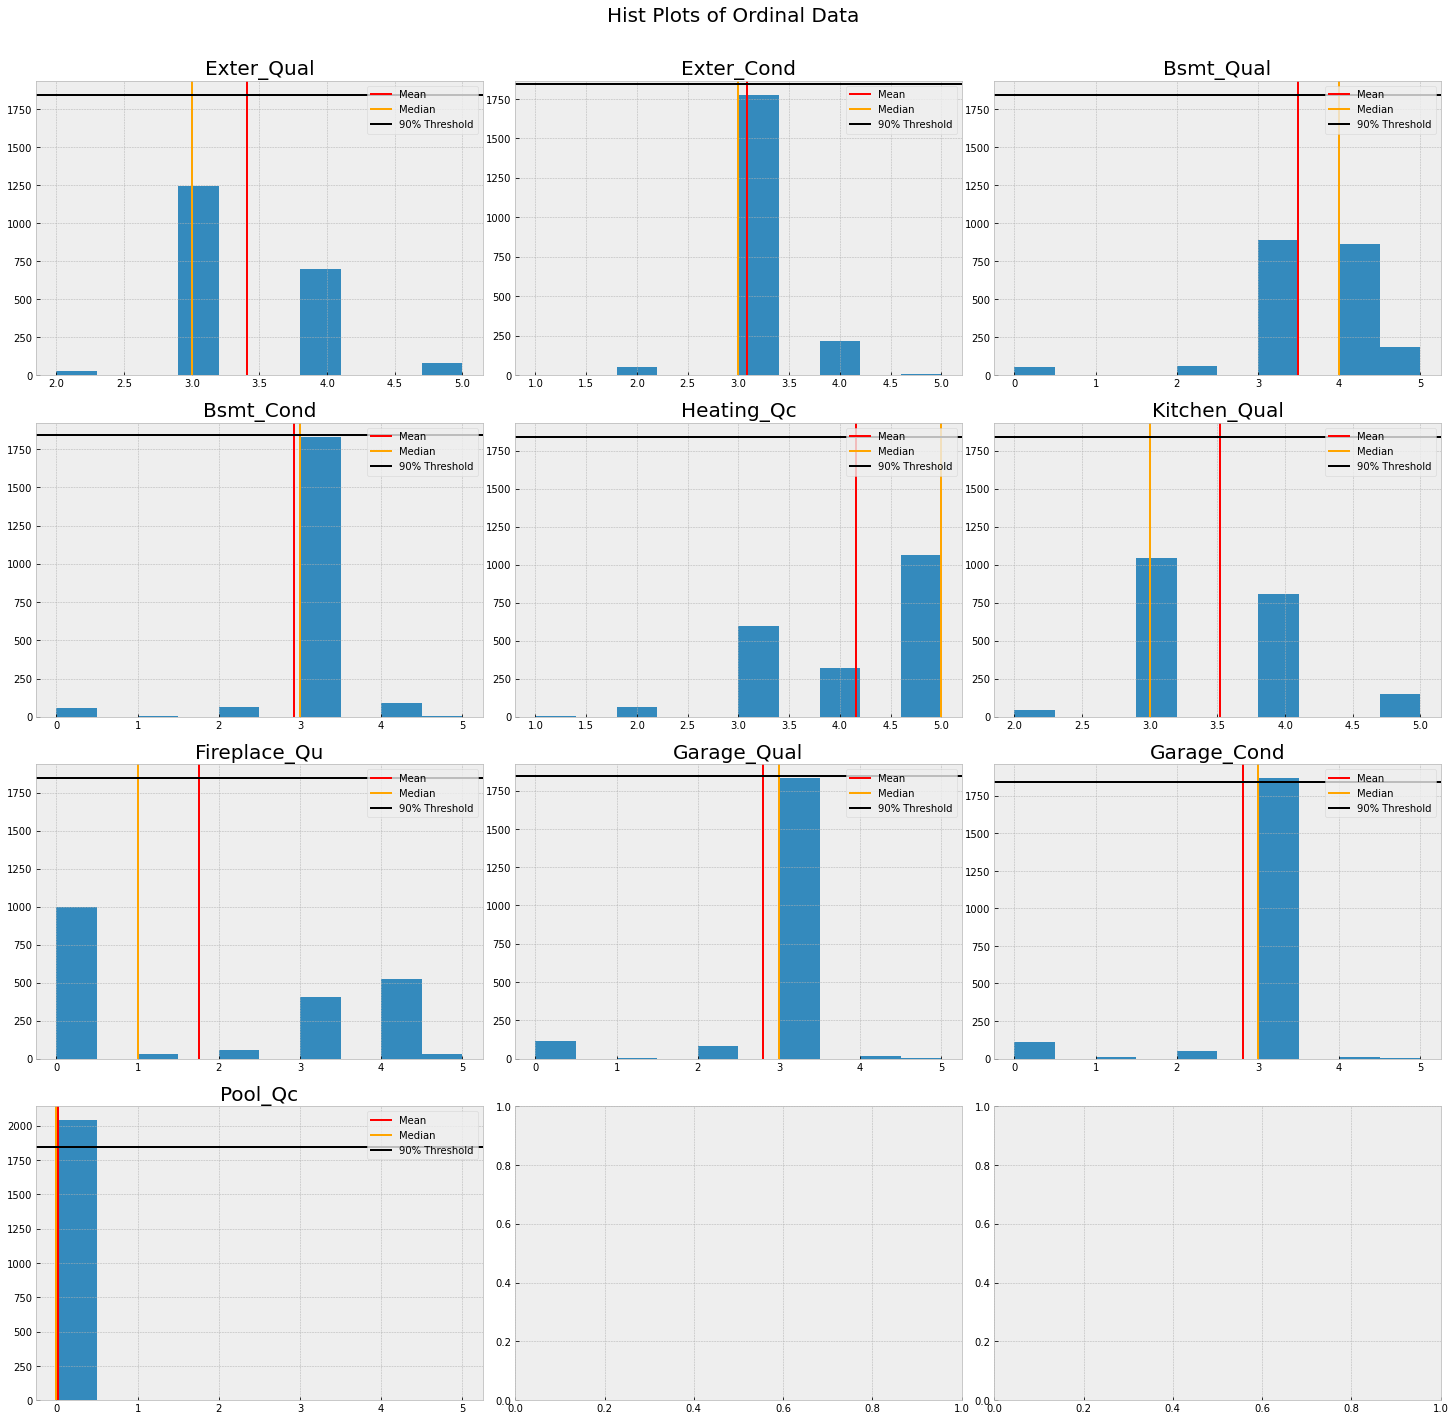

In [68]:
titles = list(train_cleaned_ordinal_1.columns)

multi_plot_hist(train_cleaned_ordinal_1, 'Hist Plots of Ordinal Data', titles, (20, 20))
plt.show();

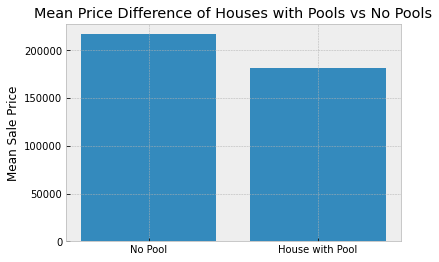

In [69]:
train_cleaned['pool'] = train_cleaned['pool_area'].apply(
    lambda x: 'No Pool' if x == 0 else 'House with Pool'
)

plt.title('Mean Price Difference of Houses with Pools vs No Pools')
plt.ylabel('Mean Sale Price')
plt.bar(
    x = train_cleaned['pool'].unique(),
    height = train_cleaned.groupby('pool')['saleprice'].mean()
);

#### Pool Variables

Although having a pool can increase the price of a house by 29,000 on average, the scarcity of information, only 9 out of 2046, means that this information could drastically skew our model if too many appear in the test set. As a result, we will drop this column, and 'poolarea' from our dataset.

In [70]:
column_drop_list.append(['pool_qc','pool_area', 'pool'])

#### Review of Additional Ordinal Variables

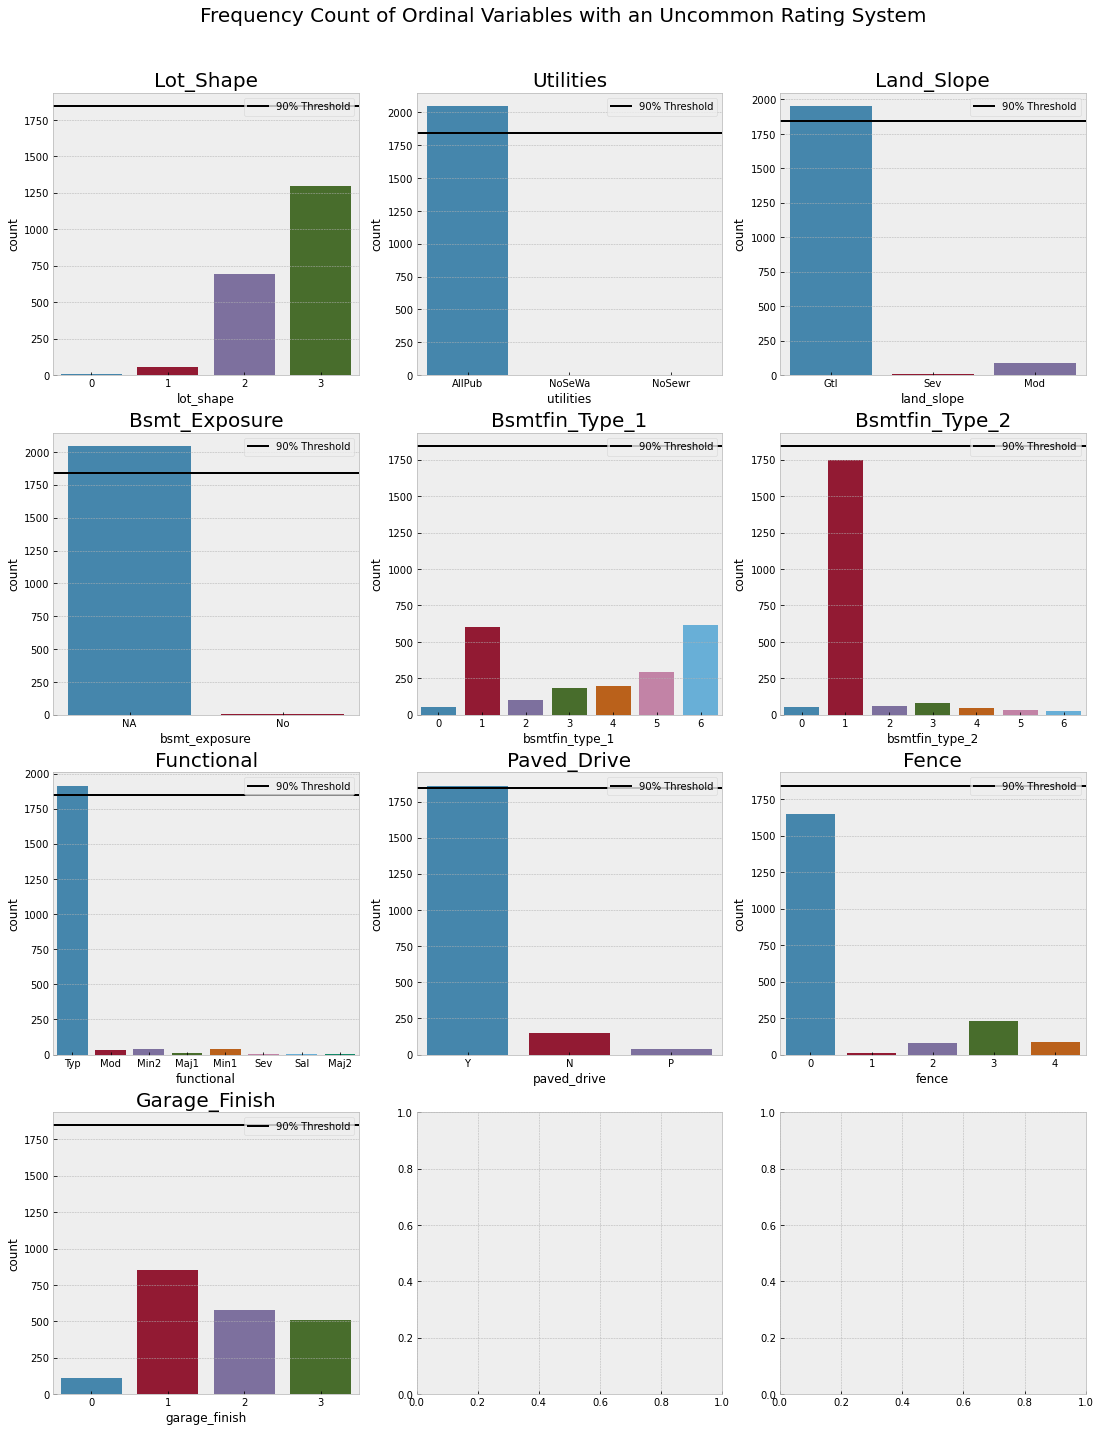

In [71]:
titles = list(train_cleaned_ordinal_2.columns)

multi_plot_bar(
    train_cleaned_ordinal_2, 
    'Frequency Count of Ordinal Variables with an Uncommon Rating System', 
    titles, 
    (15, 20)
);

In [72]:
threshold_to_drop(train_cleaned_ordinal_2);

The columns that exceeded a threhold of 90% of the population are:


### Ordinal Variables with an Uncommon Rating System

Based on most of the houses (90%) falling into one category for the following variables, they will be dropped:

<ul>
    <li> Utilities
    <li> Land Slope
    <li> Basement Exposure
    <li> Functional
    <li> Paved Drive
</ul>

In [73]:
column_drop_list.append(['utilities', 'land_slope', 'bsmt_exposure', 'functional', 'paved_drive'])

### Discrete Variables

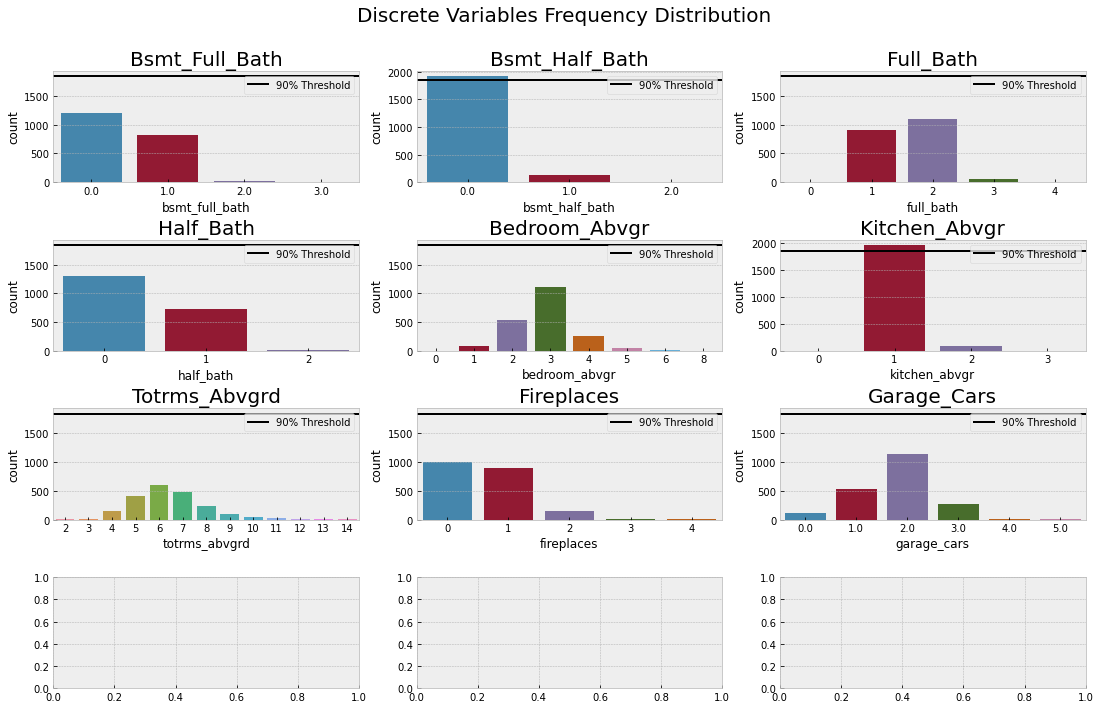

In [74]:
titles = list(train_cleaned_discrete.columns)
multi_plot_bar(train_cleaned_discrete, 'Discrete Variables Frequency Distribution', titles, (15,10))

In [75]:
threshold_to_drop(train_cleaned_discrete)

The columns that exceeded a threhold of 90% of the population are:


['bsmt_half_bath', 'kitchen_abvgr']

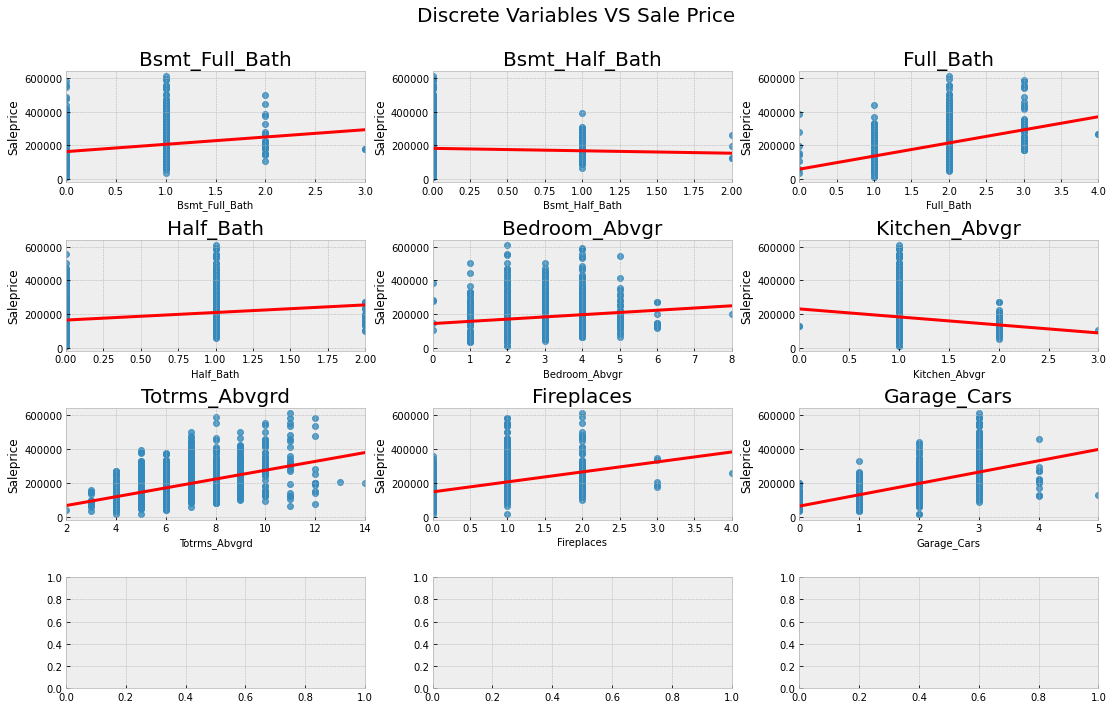

In [76]:
multi_plot_scatter(train_cleaned_discrete, 'Discrete Variables VS Sale Price', titles, (15,10))

In [77]:
column_drop_list.append(['bsmt_half_bath', 'kitchen_abvgr', 'bsmt_full_bath', 'half_bath', 'bedroom_abvgr'])

#### Discrete Variables Scatterplots

Based on most of the houses (90%) falling into one category for the following variables, they will be dropped:

<ul>
    <li> Basement Half Bath
    <li> Kitchen Above Ground
</ul>
Additionally, these variables were also dropped for a poor correlation with price:
<ol>
   <li> Basement Full Bath  
   <li> Basement Half Bath 
   <li> Half Bath   
   <li> Bedroom Above Ground
</ol>

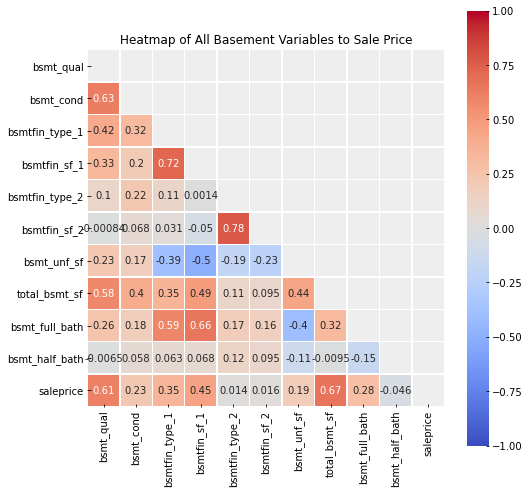

In [78]:
basement_list = [col for col in train_cleaned.columns if 'bsmt' in col or col == 'saleprice'] # Only basement variables

plt.figure(figsize=(8,8))

corr = train_cleaned[basement_list].drop(columns = 'bsmt_exposure').corr()
mask = np.zeros_like(corr)       
mask[np.triu_indices_from(mask)] = True           # Mask to block half the graph that is a copy

sns.heatmap(
    corr, 
    mask = mask, 
    square = True, 
    annot = True, 
    vmin = -1, 
    vmax = 1, 
    linewidths = .5, 
    cmap = 'coolwarm'
)

plt.title('Heatmap of All Basement Variables to Sale Price', fontsize = 12);

### Analysis of Garage Variables

The most important correlations to examine are those with a high correlation with sales price. We narrowed this to any correlation above 0.3 for sale price:
<ul>
    <li> Total Basement Square Feet
    <li> Basement Finish Type 1
    <li> Basement Finish Square Feet 1
    <li> Basement Quality  
</ul>

We will also include Basement Unfinished Square Feet, for its negative correlation to the other variables.

#### Positive Correlations
One other thing to note is the positive correlation between variables, as these may indicate variables that are measure similar things. Pairs that are correlated above 0.3 are noted in their pairs:

|Variable 1|Variables|
|---|---|
|Basement Finish Type 1|Basement Condition, Basement Finish Square Feet 1, Basement Full Bath|
|Basement Finish Square Feet 2|Basement Finish Square Feet 2, Basement Full Bath|
|Total Basement Square Feet|Basement Condition, Basement Finish Type 1 Basement Finish Square Feet 1, Basement Unfinished Square Feet|


#### Negative Correlations
Negative Correlations are also of note though obvious, unfinished garages have fewer baths and have less finished area:

|Variable 1|Variables|
|---|---|
|Basement Unfinished Square Feet|Basement Finished Square Feet,  Basement Finish Type 1, Basement Full Bath|

#### Analysis
Based on the correlations, we will additionally drop the following:
<ul>
    <li> Basement Finish Square Feet 2
    <li> Basement Finish Type 2    
</ul>

In [79]:
column_drop_list.append(['bsmtfin_type_2', 'bsmtfin_sf_2'])

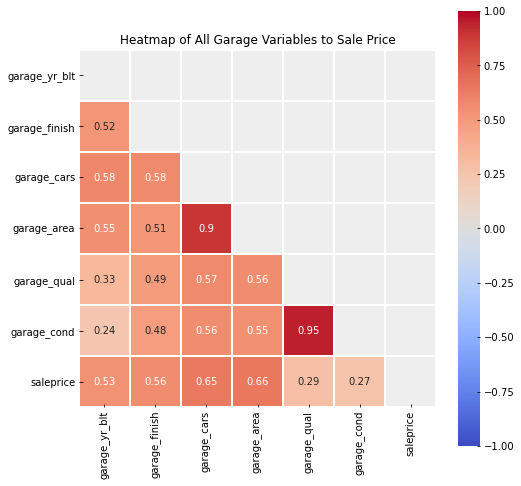

In [80]:
garage_list = [col for col in train_cleaned.columns if 'garage' in col or col == 'saleprice'] # Only garage variables

plt.figure(figsize=(8,8))

corr = train_cleaned[garage_list].corr()
mask = np.zeros_like(corr)       
mask[np.triu_indices_from(mask)] = True  # Mask to block half the graph that is a copy

sns.heatmap(
    corr, 
    mask = mask, 
    square = True, 
    annot = True, 
    vmin = -1, 
    vmax = 1, 
    linewidths = .5, 
    cmap = 'coolwarm'
)

plt.title('Heatmap of All Garage Variables to Sale Price', fontsize = 12);

### Analysis of Garage Variables

The most important correlations to examine are those with a high correlation with sales price. We narrowed this to any correlation above 0.3 or below -0.3 for sale price:
<ul>
    <li> Garage Year Built
    <li> Garage Cars
    <li> Garage Area
    <li> Garage Finish        
</ul>

#### Analysis
Based on the correlations, most of the variables are quite highly correlated with an increase in price, though quality and condition least. Additionally, Garage Area and Garage Cars are strongly correlated, as are Garage Condition and Quality.

We will likely drop Garage Cars from the dataset. Garage Area is a better indicator, as it is a continuous variable, and will also account for bike storage, or as Americans are wont to do, use the garage as a storage area or a hobby shop.

Additionally, we will finally drop Garage Year Built, as it looks like it correlates with the size of the garage, with younger garages having higher square footage, and better finishes.

Lastly, we trial either Garage Condition or Garage Quality, as the two seem to overlap almost completely.

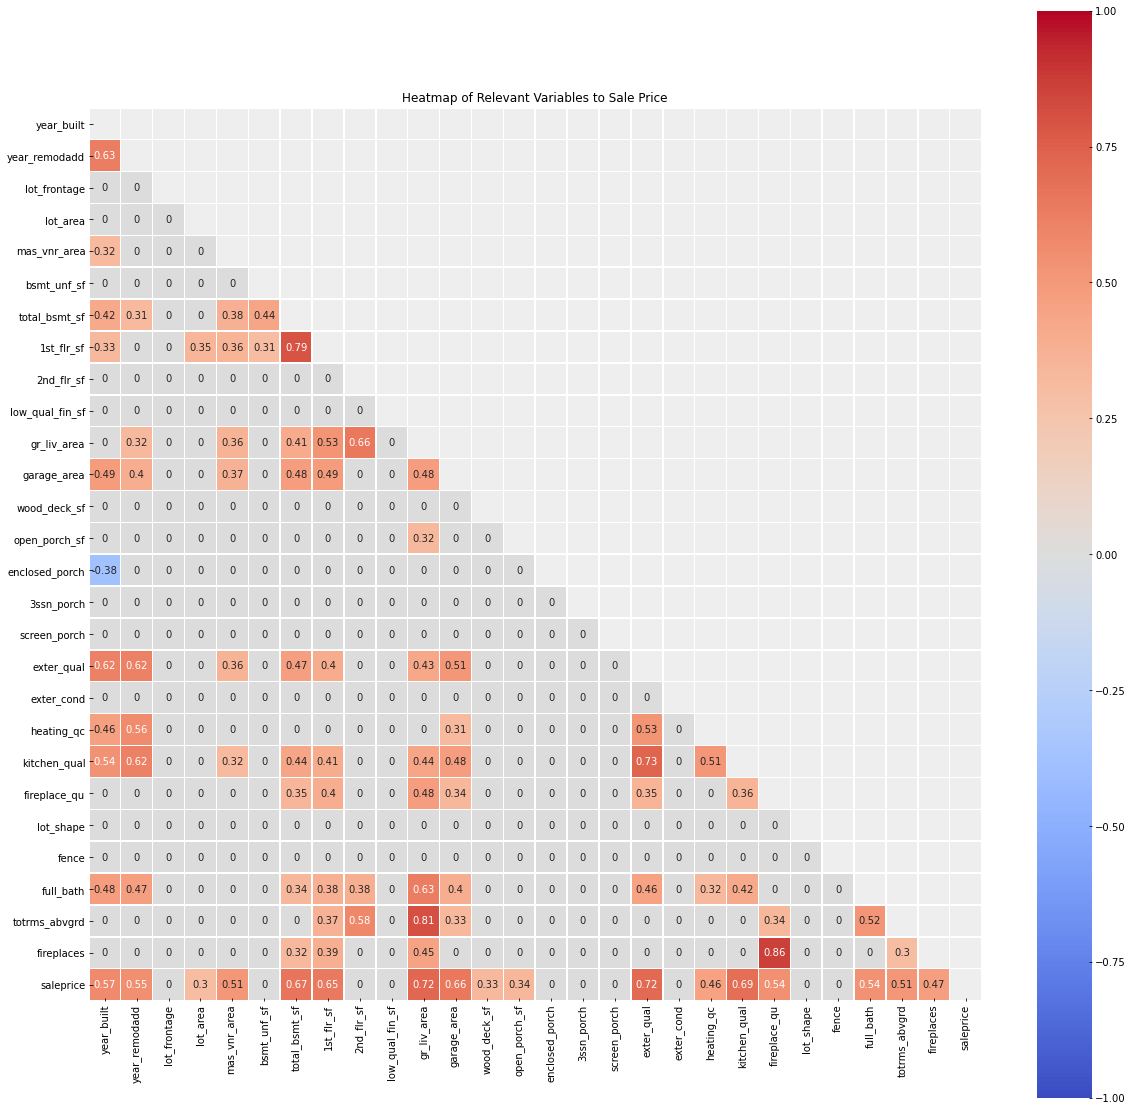

In [81]:
train_cleaned_corr = train_cleaned[
    ['year_built', 'year_remodadd', 'lot_frontage', 'lot_area', 'mas_vnr_area', 
    'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 
    'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 
    'screen_porch', 'exter_qual', 'exter_cond', 'heating_qc', 'kitchen_qual', 'fireplace_qu', 
    'lot_shape', 'fence', 'full_bath','totrms_abvgrd', 'fireplaces', 'saleprice']]

plt.figure(figsize=(20,20))

corr = train_cleaned_corr.corr()
corr[(abs(corr) < 0.3)] = 0              # Show only values with a higher correlation
mask = np.zeros_like(corr)       
mask[np.triu_indices_from(mask)] = True  # Mask to block half the graph that is a copy

sns.heatmap(corr, 
            mask = mask, 
            square = True, 
            annot = True, 
            vmin = -1, 
            vmax = 1, 
            linewidths = .5, 
            cmap = 'coolwarm'
           )

plt.title('Heatmap of Relevant Variables to Sale Price', fontsize = 12);

#### Analysis of Continuous and Discrete Variables

##### Heatmap of all variables

For this heatmap, all continuous and discrete variables were plotted for correlation, except for basement and garage, which saw 1-2 variables that best represented the group to prevent the heatpmap from being too over complicated.

##### Correlation with Sale Price

The most important correlations to examine are those with a high correlation with sales price. We will drop variables with a correlation below 0.3 on this graph: 
<ul>
    <li> Year Built
    <li> Year Remodeled/Added
    <li> Lot Area
    <li> Masonry Veneer Area
    <li> Total Basement Square Feet
    <li> 1st Floor Square Feet
    <li> Grade Living Area
    <li> Garage Area
    <li> Wood Deck Square Feet
    <li> Open Porch Square Feet
    <li> External Quality
    <li> Heating Qualty and Condition
    <li> Kitchen Quality
    <li> Fireplace Quality
    <li> Full Bath
    <li> Total Rooms Above Ground
    <li> Fireplaces
</ul> 

#### Above Ground Living Area

The high correlation with Ground Living Area and a number of variables related to living space, suggest that they might overlap as well and should be taken into consideration for variables that can be dropped or should be tested to be dropped:
<ul>
    <li> Full Bath
    <li> 1st Floor Square Feet
    <li> 2nd Floor Square Feet
    <li> Total Rooms Above Grade
</ul>

#### Dropped Variables

Based on a lack of correlation with price, we will drop the following variables:

<ul>
    <li> Lot Frontage
    <li> 2nd Floor Square Feet
    <li> Low Quality Finished Square Feet
    <li> Enclosed Porch
    <li> 3 Season Porch Area
    <li> Screen Porch
    <li> External Condition
    <li> Lot Shape
    <li> Fence
</ul>

In [82]:
column_drop_list.append(
    ['lot_frontage', '2nd_flr_sf', 'low_qual_fin_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 
     'lot_shape', 'exter_cond', 'fence', 'garage_cars', 'garage_yr_blt'])

### Further Feature Engineering

A notable number of variables have multiple categories, such as heating, which are both been numericised. As the values are inter-related, interaction columns could be made to see if these features might be better correlated.

|Variable 1|Variable 2|New Interactio Column|
|---|---|---|
|Fireplace|Fireplace Quality|fireplacexqu|
|External Condition|External Quality|extcond_qual|

In [83]:
train_cleaned['fireplacexqu'] = train_cleaned['fireplaces'] * train_cleaned['fireplace_qu']
train_cleaned['extcond_qual'] = train_cleaned['exter_qual'] * train_cleaned['exter_cond']

In [84]:
drop_list = []

# Turning the list of lists into 1 list
for sublist in column_drop_list:
    for item in sublist:
        drop_list.append(item)
        
print('The list of columns to be dropped are:')
print(drop_list)

The list of columns to be dropped are:
['id', 'pid', 'ms_subclass', 'ms_zoning', 'street', 'alley', 'roof_matl', 'heating', 'central_air', 'electrical', 'lot_config', 'house_style', 'misc_feature', 'condition_1', 'condition_2', 'mas_vnr_type', 'exterior_1st', 'exterior_2nd', 'sale_type', 'roof_style', 'land_contour', 'bldg_type', 'mo_sold', 'pool_qc', 'pool_area', 'pool', 'utilities', 'land_slope', 'bsmt_exposure', 'functional', 'paved_drive', 'bsmt_half_bath', 'kitchen_abvgr', 'bsmt_full_bath', 'half_bath', 'bedroom_abvgr', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'lot_frontage', '2nd_flr_sf', 'low_qual_fin_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'lot_shape', 'exter_cond', 'fence', 'garage_cars', 'garage_yr_blt']


In [85]:
train_cleaned.drop(columns = drop_list, inplace = True)

## Standardisation

In [86]:
# Removing the nominal values and attaching the dummified values before train_test_split
train_final = pd.concat(
    objs = [
        train_cleaned.drop(columns = (train_nominal_final or 'saleprice')),
        train_dummified
    ],
    axis = 1
)

# train, test, split
X = train_final
y = train_final['saleprice']
X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state = 42)

In [87]:
# dropping the dummified values and saleprice for standardisation
ss_train = X_train.drop(columns = train_dummified.columns)
ss_validate = X_validate.drop(columns = train_dummified.columns)
ss_train = ss_train.drop(columns = 'saleprice').reset_index(drop = True)
ss_validate = ss_validate.drop(columns = 'saleprice').reset_index(drop = True)

In [88]:
ss = StandardScaler()

# Fit and Transform the trian and validate sets
X_train_sc = ss.fit_transform(ss_train)
X_validate_sc = ss.transform(ss_validate)

In [89]:
# Concatenating the train and validate sets with the dummified columns and saleprice for modelling
X_train_ss = pd.concat(
    objs = [
        pd.DataFrame(                                      # Standardised variables
            columns = ss_train.columns,
            data = X_train_sc
        ).drop(
            columns = [
            'misc_val', 'bsmtfin_sf_1', 'bsmtfin_type_1'        # Drop variables no longer used
            ]
        ), 
        X_train[train_dummified.columns].reset_index(drop = True), # Dummified variables
        X_train['saleprice'].reset_index(drop = True)              # Saleprice column
    ], axis = 1
)

X_validate_ss = pd.concat(
    objs = [
        pd.DataFrame(
            columns = ss_validate.columns,
            data = X_validate_sc
        ).drop(
            columns = [
            'misc_val', 'bsmtfin_sf_1', 'bsmtfin_type_1'
            ]
        ), 
        X_validate[train_dummified.columns].reset_index(drop = True),
        X_validate['saleprice'].reset_index(drop = True)
    ], axis = 1
)

In [90]:
X_train_ss.to_csv('datasets/train_1.csv') # Train data scaled for testing
X_validate_ss.to_csv('datasets/validate_1.csv') #Validate data scaled on Train model for testing

In [91]:
# Complete train data for modelling and fitting before the test
train_cleaned_scale = train_cleaned.drop(columns = keep_nominal) # Drop all nominal variables
train_cleaned_scale = train_cleaned_scale.drop(columns = ['saleprice']) # Drop salesprice before standardisation
ss = StandardScaler()
train_cleaned_scaled = ss.fit_transform(train_cleaned_scale) # scale

# Concantenate
train_final = pd.concat(                                       
    objs = [
        # Scaled DataFrame
        pd.DataFrame(
            columns = train_cleaned_scale.columns,
            data = train_cleaned_scaled
        ).drop(
            # Columns had to be retained initially to scale with the initial training data
            columns = [
            'misc_val', 'bsmtfin_sf_1', 'bsmtfin_type_1' 
        ]),
        # One Hot Encoded Values
        train_dummified,
        # Saleprice
        pd.DataFrame(
            columns = ['saleprice'],
            data = train_cleaned['saleprice']
        )
    ], axis = 1
)


## Cleaning and Transforming the Test Data

In [92]:
test_cleaned = test_intermed

# Add house age as a feature
test_cleaned = test_cleaned.apply(house_age, axis=1)

# Add additional engineered features
test_cleaned = test_cleaned.apply(pos_feature, axis=1)
test_cleaned['fireplacexqu'] = test_cleaned['fireplaces'] * test_cleaned['fireplace_qu']
test_cleaned['extcond_qual'] = test_cleaned['exter_qual'] * test_cleaned['exter_cond']
test_cleaned['neighborhood'] = test_cleaned['neighborhood'].map(exterior_2_dict_map)

# One Hot Encode variables
test_dummified_values = ohe.transform(test_cleaned[keep_nominal]) # Transform test model on training fit
column_names = ohe.get_feature_names(keep_nominal)                         # Feature Names
test_dummified = pd.DataFrame(test_dummified_values, columns = column_names) # Dataframe with nominal values

# Drop irrelevant columns
test_cleaned.drop(columns = 
                  ['id', 'pid', 'ms_subclass', 'ms_zoning', 'street', 'alley', 'roof_matl', 'heating', 
                   'central_air', 'electrical', 'lot_config', 'house_style', 'misc_feature', 'condition_1', 
                   'condition_2', 'roof_style', 'land_contour', 'bldg_type', 'mo_sold', 'pool_qc', 
                   'pool_area', 'utilities', 'land_slope', 'bsmt_exposure', 'functional', 'paved_drive', 
                   'bsmt_half_bath', 'kitchen_abvgr', 'bsmt_full_bath', 'half_bath', 'bedroom_abvgr', 
                   'bsmtfin_type_2', 'bsmtfin_sf_2', 'lot_frontage', '2nd_flr_sf', 'low_qual_fin_sf', 
                   'enclosed_porch', '3ssn_porch', 'screen_porch', 'lot_shape', 'exter_cond', 'fence', 
                   'garage_cars', 'garage_yr_blt', 'neighborhood', 'mas_vnr_type', 'foundation', 
                   'exterior_1st', 'exterior_2nd', 'garage_type', 'sale_type'
                  ], inplace = True)

# Standardise based on all train data
test_scaled = ss.transform(test_cleaned)

# Turning data into a dataframe
test_complete = pd.concat(
    objs = [
        pd.DataFrame(
            columns = test_cleaned.columns,
            data = test_scaled
        ).drop(
            # Columns had to be retained initially to scale with the initial training data
            columns = [
            'misc_val', 'bsmtfin_sf_1', 'bsmtfin_type_1' 
            ]
        ),
        # Adding One Hot Encoded Columns
        test_dummified
    ],
        axis = 1
)
        

# Save to disk
test_complete.to_csv('datasets/new_test_2.csv')

<a id='SavingData'></a>
## Saving Data for Model Testing

In [93]:
# Checking for column disparity
set(train_final.columns) - set(test_complete.columns)

{'saleprice'}

In [94]:
set(test_complete.columns) - set(train_final.columns)

set()

In [95]:
train_final.to_csv('datasets/train_final.csv')

In [96]:
# Final Check
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lot_area             2049 non-null   float64
 1   overall_qual         2049 non-null   float64
 2   overall_cond         2049 non-null   float64
 3   year_built           2049 non-null   float64
 4   year_remodadd        2049 non-null   float64
 5   mas_vnr_area         2049 non-null   float64
 6   exter_qual           2049 non-null   float64
 7   bsmt_qual            2049 non-null   float64
 8   bsmt_cond            2049 non-null   float64
 9   bsmt_unf_sf          2049 non-null   float64
 10  total_bsmt_sf        2049 non-null   float64
 11  heating_qc           2049 non-null   float64
 12  1st_flr_sf           2049 non-null   float64
 13  gr_liv_area          2049 non-null   float64
 14  full_bath            2049 non-null   float64
 15  kitchen_qual         2049 non-null   f